***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Vanilla Helmholtz Machine


*Updated:* Feb 8, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * torch.where(q != 0, torch.log(q), -100) + (1-y) * torch.where(1-q != 0, torch.log(1-q), -100)).mean()
    return loss

In [7]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [8]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [9]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [10]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [11]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.to('cpu').numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [12]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [13]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [14]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * torch.where(P != 0, torch.log(P), -100)).sum(axis=1,keepdims=True)
    return H

In [15]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber*torch.where(P_ber!=0,torch.log(P_ber),-100)+(1-P_ber)*torch.where((1-P_ber)!=0,torch.log(1-P_ber),-100))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [16]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [17]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100) + \
                    (1-p)*torch.where(1-p != 0, torch.log(1-p), -100) - (1-p)*torch.where(1-q != 0, torch.log(1-q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [18]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [19]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [20]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

## Model

In [21]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [22]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [23]:
n_layer = len(n_dz)
n_layer

6

In [24]:
n_d = n_dz[0]
n_d

tensor(12)

In [25]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [26]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [27]:
Phi,Theta = para_init(n_dz)
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [28]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [29]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [30]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785])

In [31]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Recog_D_KL_Layer_0')
for i in range(n_layer-1):
    if i > 0:
        col_list.append('Recog_H_Layer_'+str(i))
        col_list.append('Recog_I_Layer_'+str(i))
        col_list.append('Recog_D_KL_Layer_'+str(i))
    col_list.append('Gen_H_Layer_'+str(i))
    col_list.append('Gen_I_Layer_'+str(i))
    col_list.append('Gen_D_KL_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Recog_D_KL_Layer_0',
 'Gen_H_Layer_0',
 'Gen_I_Layer_0',
 'Gen_D_KL_Layer_0',
 'Recog_H_Layer_1',
 'Recog_I_Layer_1',
 'Recog_D_KL_Layer_1',
 'Gen_H_Layer_1',
 'Gen_I_Layer_1',
 'Gen_D_KL_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_2',
 'Recog_D_KL_Layer_2',
 'Gen_H_Layer_2',
 'Gen_I_Layer_2',
 'Gen_D_KL_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_3',
 'Recog_D_KL_Layer_3',
 'Gen_H_Layer_3',
 'Gen_I_Layer_3',
 'Gen_D_KL_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_4',
 'Recog_D_KL_Layer_4',
 'Gen_H_Layer_4',
 'Gen_I_Layer_4',
 'Gen_D_KL_Layer_4']

In [32]:
len(col_list)

37

### On-line Training

In [50]:
# for e in range(epoch):
#     Loss_W = 0
#     Loss_S = 0
#     index = np.random.permutation(n_data)
#     for i in range(n_data):
#         Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev)
#         Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#         Loss_W += Loss_wake
#         Loss_S += Loss_sleep
#     print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)

In [99]:
Analytic_ws_online = pd.DataFrame(columns=col_list)
Analytic_ws_online

Empty DataFrame
Columns: [Phi_Loss_Layer_1, Phi_Loss_Layer_2, Phi_Loss_Layer_3, Phi_Loss_Layer_4, Theta_Loss_Layer_0, Theta_Loss_Layer_1, Theta_Loss_Layer_2, Theta_Loss_Layer_3, Theta_Loss_Layer_4, Recog_D_KL_Layer_0, Gen_H_Layer_0, Gen_I_Layer_0, Gen_D_KL_Layer_0, Recog_H_Layer_1, Recog_I_Layer_1, Recog_D_KL_Layer_1, Gen_H_Layer_1, Gen_I_Layer_1, Gen_D_KL_Layer_1, Recog_H_Layer_2, Recog_I_Layer_2, Recog_D_KL_Layer_2, Gen_H_Layer_2, Gen_I_Layer_2, Gen_D_KL_Layer_2, Recog_H_Layer_3, Recog_I_Layer_3, Recog_D_KL_Layer_3, Gen_H_Layer_3, Gen_I_Layer_3, Gen_D_KL_Layer_3, Recog_H_Layer_4, Recog_I_Layer_4, Recog_D_KL_Layer_4, Gen_H_Layer_4, Gen_I_Layer_4, Gen_D_KL_Layer_4]
Index: []

[0 rows x 37 columns]

In [100]:
Phi,Theta = para_init(n_dz)

In [157]:
Analytic_ws_online_continue = pd.read_csv('Analytic_ws_online.csv', sep=",")
Analytic_ws_online_continue

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0           0.549195          0.605361          0.602305          0.605072   
1           0.247130          0.140485          0.292811          0.228170   
2           0.208765          0.116884          0.190964          0.283248   
3           0.120577          0.086833          0.097020          0.084723   
4           0.107413          0.130565          0.081919          0.069047   
5           0.101646          0.032995          0.053908          0.032856   
6           0.092104          0.099257          0.054447          0.055602   
7           0.104955          0.114775          0.035502          0.028181   
8           0.085574          0.017484          0.034972          0.057759   
9           0.102654          0.016744          0.046859          0.113483   
10          0.048808          0.076215          0.037040          0.104087   
11          0.042188          0.073980          0.078447          0.064207   
12          0.041930          0.037594          0.175664          0.073402   
13          0.036384          0.067067          0.111265          0.024693   
14          0.043988          0.058469          0.032961          0.171641   
15          0.071364          0.059315          0.031438          0.026041   
16          0.038147          0.033740          0.027123          0.018729   
17          0.032257          0.098565          0.025683          0.038827   
18          0.038001          0.065386          0.019567          0.081627   
19          0.062263          0.074889          0.098646          0.040388   
20          0.045273          0.026735          0.017913          0.012981   
21          0.032325          0.014925          0.028447          0.020625   
22          0.051500          0.013237          0.028431          0.017887   
23          0.042869          0.024118          0.018024          0.013633   
24          0.062926          0.036029          0.012710          0.013420   
25          0.038477          0.012195          0.009415          0.022800   
26          0.067314          0.012821          0.011845          0.011990   
27          0.053344          0.012650          0.016681          0.024536   
28          0.039859          0.068511          0.013531          0.012964   
29          0.067761          0.026127          0.025386          0.012989   
30          0.100556          0.051426          0.022353          0.006547   
31          0.057945          0.013846          0.030612          0.006139   
32          0.073480          0.009340          0.013665          0.006390   
33          0.061145          0.010080          0.020461          0.010890   
34          0.057243          0.001832          0.018436          0.006864   
35          0.122582          0.007146          0.017915          0.003253   
36          0.131615          0.007733          0.015000          0.010627   
37          0.082704          0.006973          0.010611          0.000658   
38          0.048143          0.010464          0.013173          0.003665   
39          0.057701          0.011009          0.008486          0.003271   
40          0.060796          0.021362          0.014543          0.010405   
41          0.053149          0.015102          0.008875          0.006190   
42          0.077328          0.028967          0.015222          0.006163   
43          0.039187          0.025989          0.023160          0.003290   
44          0.028577          0.028722          0.040583          0.008116   
45          0.033003          0.020108          0.018605          0.000494   
46          0.043447          0.021662          0.011825          0.008757   
47          0.031109          0.025863          0.016625          0.000444   
48          0.060851          0.041906          0.024772          0.003371   
49          0.051012          0.019542          0.044022          0.004926   
50          0.041263      

In [36]:
para = np.load('Parameters_ws_online_continue.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [176]:
batch_size = 1
lr = 0.1
epoch = 500

In [177]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(n_data):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e % 10 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        wake_ct = {}
        sleep_ct = {}
        wake_ct['Layer 0: dist'] = data_dist
        dist_ct_pre_s = torch.ones(1,device=dev)
        dist_ct_pre_w = data_dist
        for i in range(n_layer-1):
            prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
            sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
            sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
            dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

            if i < n_layer-2:
                prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
                wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
                wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
                dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
        for i in range(n_layer-1):
            dist_w = wake_ct['Layer '+str(i)+': dist']
            dist_s = sleep_ct['Layer '+str(i)+': dist']
            if i == 0:
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            if i > 0:
                H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
                stat.append(H_Y_w)
                H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
                I_w = H_Y_w - H_YX_w
                stat.append(I_w)
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
            stat.append(H_Y_s)
            H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
            I_s = H_Y_s - H_YX_s
            stat.append(I_s)
            D_KL_s = KL_divergence(dist_w,dist_s).item()
            stat.append(D_KL_s)
        Analytic_ws_online_continue.loc[len(Analytic_ws_online_continue)] = stat

Loss_wake: tensor([0.0000e+00, 3.1643e-02, 4.8168e-05, 5.7743e-03, 4.7694e-04])     Loss_sleep: tensor([0.4640, 0.2015, 0.0028, 0.0106, 0.0006])
Loss_wake: tensor([0.0000, 0.0358, 0.0013, 0.0106, 0.0004])     Loss_sleep: tensor([4.6580e-01, 2.0255e-01, 6.3175e-05, 9.1041e-03, 3.1711e-03])
Loss_wake: tensor([0.0000, 0.0368, 0.0016, 0.0088, 0.0032])     Loss_sleep: tensor([4.7100e-01, 1.9857e-01, 6.0491e-05, 8.8121e-03, 5.7274e-03])
Loss_wake: tensor([0.0000e+00, 3.3789e-02, 6.0310e-05, 6.9642e-03, 6.0317e-03])     Loss_sleep: tensor([0.4592, 0.2126, 0.0014, 0.0107, 0.0006])
Loss_wake: tensor([0.0000, 0.0327, 0.0036, 0.0072, 0.0086])     Loss_sleep: tensor([4.7339e-01, 1.9180e-01, 5.9675e-05, 7.2070e-03, 8.4122e-03])
Loss_wake: tensor([0.0000, 0.0362, 0.0007, 0.0095, 0.0031])     Loss_sleep: tensor([4.6552e-01, 2.0528e-01, 5.6801e-05, 4.7378e-03, 5.6504e-04])
Loss_wake: tensor([0.0000e+00, 4.5386e-02, 8.1615e-05, 4.9072e-03, 3.1017e-03])     Loss_sleep: tensor([0.4496, 0.2283, 0.0013, 0.

Loss_wake: tensor([0.0000e+00, 3.3069e-02, 6.6119e-05, 7.4604e-03, 6.5539e-03])     Loss_sleep: tensor([4.6625e-01, 1.9929e-01, 7.2674e-05, 3.3198e-03, 1.1440e-02])
Loss_wake: tensor([0.0000e+00, 4.1360e-02, 7.6255e-05, 3.2410e-03, 3.5930e-03])     Loss_sleep: tensor([4.5872e-01, 2.0847e-01, 6.8974e-05, 1.9218e-03, 3.0750e-03])
Loss_wake: tensor([0.0000e+00, 3.2377e-02, 6.3770e-05, 8.5452e-03, 3.0636e-03])     Loss_sleep: tensor([4.6892e-01, 1.9496e-01, 1.3251e-03, 4.5153e-03, 3.8516e-04])
Loss_wake: tensor([0.0000e+00, 3.0199e-02, 6.2210e-05, 4.6995e-03, 3.4672e-04])     Loss_sleep: tensor([4.6892e-01, 1.8912e-01, 6.9954e-05, 4.7335e-03, 3.2609e-03])
Loss_wake: tensor([0.0000e+00, 3.7891e-02, 7.8422e-05, 5.9735e-03, 2.8457e-04])     Loss_sleep: tensor([4.5022e-01, 2.2226e-01, 6.7050e-05, 5.8618e-03, 3.6165e-04])
Loss_wake: tensor([0.0000e+00, 3.8583e-02, 6.3163e-05, 6.0537e-03, 3.0792e-03])     Loss_sleep: tensor([0.4571, 0.2111, 0.0013, 0.0046, 0.0031])
Loss_wake: tensor([0.0000, 0.0

Loss_wake: tensor([0.0000, 0.0352, 0.0009, 0.0032, 0.0002])     Loss_sleep: tensor([4.6254e-01, 2.0200e-01, 9.3243e-05, 8.0967e-03, 2.8228e-04])
Loss_wake: tensor([0.0000, 0.0515, 0.0009, 0.0045, 0.0002])     Loss_sleep: tensor([4.5035e-01, 2.2473e-01, 1.2076e-03, 4.7019e-03, 2.7050e-04])
Loss_wake: tensor([0.0000, 0.0385, 0.0012, 0.0055, 0.0002])     Loss_sleep: tensor([4.6161e-01, 2.0998e-01, 9.5000e-05, 7.2345e-03, 2.5980e-04])
Loss_wake: tensor([0.0000, 0.0443, 0.0015, 0.0115, 0.0002])     Loss_sleep: tensor([0.4545, 0.2222, 0.0026, 0.0086, 0.0030])
Loss_wake: tensor([0.0000, 0.0410, 0.0015, 0.0101, 0.0001])     Loss_sleep: tensor([4.5327e-01, 2.2309e-01, 1.1808e-03, 5.5272e-03, 2.5801e-04])
Loss_wake: tensor([0.0000, 0.0431, 0.0013, 0.0136, 0.0001])     Loss_sleep: tensor([0.4514, 0.2245, 0.0012, 0.0141, 0.0066])
Loss_wake: tensor([0.0000e+00, 3.9921e-02, 9.7096e-05, 1.1222e-02, 1.2259e-04])     Loss_sleep: tensor([4.5553e-01, 2.1441e-01, 1.2100e-04, 9.4360e-03, 2.5212e-04])
Loss_

Loss_wake: tensor([0.0000e+00, 2.9539e-02, 6.8482e-05, 1.3565e-02, 3.6634e-04])     Loss_sleep: tensor([0.4628, 0.1988, 0.0013, 0.0110, 0.0030])
Loss_wake: tensor([0.0000, 0.0313, 0.0017, 0.0087, 0.0003])     Loss_sleep: tensor([4.6418e-01, 1.9885e-01, 1.0247e-03, 9.0240e-03, 2.6195e-04])
Loss_wake: tensor([0.0000, 0.0399, 0.0029, 0.0086, 0.0002])     Loss_sleep: tensor([4.5852e-01, 2.1493e-01, 9.7926e-05, 7.1009e-03, 6.2972e-03])
Loss_wake: tensor([0.0000, 0.0265, 0.0001, 0.0150, 0.0058])     Loss_sleep: tensor([4.7004e-01, 1.8949e-01, 1.5351e-03, 9.4288e-03, 2.6395e-04])
Loss_wake: tensor([0.0000e+00, 2.6024e-02, 9.7747e-05, 4.8720e-03, 2.9026e-04])     Loss_sleep: tensor([4.6820e-01, 1.9231e-01, 8.7886e-05, 6.7767e-03, 6.6908e-03])
Loss_wake: tensor([0.0000, 0.0364, 0.0010, 0.0116, 0.0002])     Loss_sleep: tensor([4.6015e-01, 2.1413e-01, 8.4729e-05, 1.2007e-02, 2.6283e-04])
Loss_wake: tensor([0.0000e+00, 3.3671e-02, 9.1362e-05, 3.5669e-03, 2.0517e-04])     Loss_sleep: tensor([4.6131

Loss_wake: tensor([0.0000, 0.0289, 0.0003, 0.0138, 0.0032])     Loss_sleep: tensor([4.6897e-01, 1.8601e-01, 2.9510e-03, 1.1127e-02, 1.7209e-04])
Loss_wake: tensor([0.0000, 0.0259, 0.0003, 0.0098, 0.0033])     Loss_sleep: tensor([4.6846e-01, 1.8577e-01, 1.0675e-04, 1.2917e-02, 3.2966e-03])
Loss_wake: tensor([0.0000, 0.0270, 0.0025, 0.0122, 0.0003])     Loss_sleep: tensor([0.4654, 0.1929, 0.0023, 0.0068, 0.0033])
Loss_wake: tensor([0.0000, 0.0193, 0.0011, 0.0057, 0.0003])     Loss_sleep: tensor([0.4728, 0.1742, 0.0015, 0.0066, 0.0032])
Loss_wake: tensor([0.0000, 0.0245, 0.0002, 0.0117, 0.0002])     Loss_sleep: tensor([4.7143e-01, 1.8298e-01, 1.5354e-03, 6.3518e-03, 1.8121e-04])
Loss_wake: tensor([0.0000, 0.0277, 0.0025, 0.0082, 0.0033])     Loss_sleep: tensor([0.4695, 0.1822, 0.0036, 0.0094, 0.0039])
Loss_wake: tensor([0.0000, 0.0227, 0.0021, 0.0080, 0.0002])     Loss_sleep: tensor([4.7012e-01, 1.8414e-01, 1.1714e-03, 1.0739e-02, 1.7542e-04])
Loss_wake: tensor([0.0000, 0.0222, 0.0012, 0.

Loss_wake: tensor([0.0000, 0.0291, 0.0069, 0.0182, 0.0029])     Loss_sleep: tensor([0.4711, 0.1820, 0.0049, 0.0118, 0.0030])
Loss_wake: tensor([0.0000, 0.0435, 0.0068, 0.0094, 0.0033])     Loss_sleep: tensor([0.4639, 0.2079, 0.0028, 0.0137, 0.0034])
Loss_wake: tensor([0.0000, 0.0648, 0.0032, 0.0112, 0.0032])     Loss_sleep: tensor([0.4570, 0.2330, 0.0046, 0.0126, 0.0031])
Loss_wake: tensor([0.0000, 0.0561, 0.0030, 0.0215, 0.0029])     Loss_sleep: tensor([0.4549, 0.2291, 0.0035, 0.0134, 0.0068])
Loss_wake: tensor([0.0000, 0.0288, 0.0058, 0.0175, 0.0002])     Loss_sleep: tensor([0.4723, 0.1862, 0.0059, 0.0232, 0.0030])
Loss_wake: tensor([0.0000, 0.0291, 0.0045, 0.0165, 0.0032])     Loss_sleep: tensor([4.7379e-01, 1.8621e-01, 5.0085e-03, 1.9870e-02, 2.8902e-04])
Loss_wake: tensor([0.0000, 0.0545, 0.0045, 0.0225, 0.0055])     Loss_sleep: tensor([0.4575, 0.2274, 0.0021, 0.0147, 0.0030])
Loss_wake: tensor([0.0000, 0.0548, 0.0030, 0.0138, 0.0035])     Loss_sleep: tensor([0.4663, 0.2206, 0.002

Loss_wake: tensor([0.0000, 0.0758, 0.0036, 0.0123, 0.0063])     Loss_sleep: tensor([0.4485, 0.2589, 0.0052, 0.0085, 0.0030])
Loss_wake: tensor([0.0000, 0.0802, 0.0171, 0.0129, 0.0115])     Loss_sleep: tensor([4.4511e-01, 2.6547e-01, 1.4461e-02, 1.2373e-02, 4.2498e-04])
Loss_wake: tensor([0.0000, 0.0798, 0.0136, 0.0153, 0.0028])     Loss_sleep: tensor([0.4443, 0.2629, 0.0153, 0.0146, 0.0034])
Loss_wake: tensor([0.0000, 0.0520, 0.0112, 0.0046, 0.0056])     Loss_sleep: tensor([0.4592, 0.2252, 0.0135, 0.0043, 0.0082])
Loss_wake: tensor([0.0000, 0.0336, 0.0117, 0.0149, 0.0028])     Loss_sleep: tensor([0.4750, 0.1892, 0.0121, 0.0143, 0.0030])
Loss_wake: tensor([0.0000, 0.0265, 0.0127, 0.0079, 0.0030])     Loss_sleep: tensor([0.4776, 0.1824, 0.0136, 0.0099, 0.0030])
Loss_wake: tensor([0.0000, 0.0323, 0.0091, 0.0102, 0.0004])     Loss_sleep: tensor([0.4758, 0.1862, 0.0096, 0.0148, 0.0030])
Loss_wake: tensor([0.0000, 0.0460, 0.0022, 0.0081, 0.0030])     Loss_sleep: tensor([4.6795e-01, 2.0663e-0

Loss_wake: tensor([0.0000, 0.1008, 0.0064, 0.0523, 0.0030])     Loss_sleep: tensor([4.2005e-01, 3.1653e-01, 4.4418e-03, 5.3899e-02, 3.5142e-04])
Loss_wake: tensor([0.0000, 0.1032, 0.0038, 0.0491, 0.0030])     Loss_sleep: tensor([0.4197, 0.3108, 0.0051, 0.0492, 0.0030])
Loss_wake: tensor([0.0000, 0.0916, 0.0090, 0.0258, 0.0005])     Loss_sleep: tensor([0.4284, 0.2989, 0.0066, 0.0297, 0.0030])
Loss_wake: tensor([0.0000, 0.0828, 0.0126, 0.0274, 0.0035])     Loss_sleep: tensor([0.4436, 0.2641, 0.0104, 0.0304, 0.0030])
Loss_wake: tensor([0.0000, 0.0573, 0.0106, 0.0233, 0.0030])     Loss_sleep: tensor([4.5764e-01, 2.3569e-01, 1.3074e-02, 2.0578e-02, 3.4698e-04])
Loss_wake: tensor([0.0000, 0.0689, 0.0066, 0.0313, 0.0030])     Loss_sleep: tensor([4.5519e-01, 2.4556e-01, 7.8190e-03, 3.0122e-02, 3.2694e-04])
Loss_wake: tensor([0.0000, 0.0702, 0.0081, 0.0416, 0.0004])     Loss_sleep: tensor([4.4874e-01, 2.5233e-01, 4.2072e-03, 4.3720e-02, 3.0942e-04])
Loss_wake: tensor([0.0000, 0.0794, 0.0025, 0.

Loss_wake: tensor([0.0000, 0.0623, 0.0032, 0.0198, 0.0031])     Loss_sleep: tensor([4.4926e-01, 2.4517e-01, 3.9403e-03, 2.3857e-02, 2.4929e-04])
Loss_wake: tensor([0.0000, 0.0792, 0.0011, 0.0193, 0.0002])     Loss_sleep: tensor([4.4365e-01, 2.6374e-01, 2.2827e-04, 1.4214e-02, 3.0357e-03])
Loss_wake: tensor([0.0000, 0.0768, 0.0042, 0.0166, 0.0035])     Loss_sleep: tensor([0.4449, 0.2585, 0.0015, 0.0079, 0.0039])
Loss_wake: tensor([0.0000, 0.0529, 0.0003, 0.0062, 0.0002])     Loss_sleep: tensor([4.5812e-01, 2.2285e-01, 2.3703e-03, 6.9889e-03, 2.4090e-04])
Loss_wake: tensor([0.0000, 0.0435, 0.0012, 0.0083, 0.0002])     Loss_sleep: tensor([4.6478e-01, 2.0091e-01, 2.0854e-04, 9.8230e-03, 2.3243e-04])
Loss_wake: tensor([0.0000, 0.0326, 0.0012, 0.0066, 0.0065])     Loss_sleep: tensor([4.6356e-01, 2.0131e-01, 2.6532e-03, 8.0411e-03, 2.2463e-04])
Loss_wake: tensor([0.0000, 0.0398, 0.0013, 0.0122, 0.0032])     Loss_sleep: tensor([4.6783e-01, 2.0666e-01, 1.8624e-04, 7.8896e-03, 9.4566e-03])
Loss_

In [178]:
Analytic_ws_online_continue

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0            0.549195          0.605361          0.602305          0.605072   
1            0.247130          0.140485          0.292811          0.228170   
2            0.208765          0.116884          0.190964          0.283248   
3            0.120577          0.086833          0.097020          0.084723   
4            0.107413          0.130565          0.081919          0.069047   
..                ...               ...               ...               ...   
205          0.089353          0.001254          0.014084          0.003035   
206          0.080666          0.001111          0.026907          0.000248   
207          0.057315          0.000254          0.026245          0.003796   
208          0.032633          0.001152          0.006606          0.006463   
209          0.077711          0.001142          0.010162          0.000267   

     Theta_Loss_Layer_0  Theta_Loss_Layer_1  Theta_Loss_Layer_2  \
0              0.622563            0.540904            0.589824   
1              0.548773            0.328138            0.153250   
2              0.515566            0.302988            0.132794   
3              0.531883            0.222154            0.089573   
4              0.520346            0.206933            0.144428   
..                  ...                 ...                 ...   
205            0.424705            0.301804            0.002709   
206            0.448221            0.268555            0.003719   
207            0.442275            0.236673            0.001337   
208            0.463563            0.201312            0.002653   
209            0.432908            0.276514            0.002301   

     Theta_Loss_Layer_3  Theta_Loss_Layer_4  Recog_D_KL_Layer_0  ...  \
0              0.603657            0.627713           33.296188  ...   
1              0.300363            0.230656           15.386729  ...   
2              0.193816            0.335078           18.560917  ...   
3              0.106127            0.078722           19.667295  ...   
4              0.087216            0.078608           16.237511  ...   
..                  ...                 ...                 ...  ...   
205            0.017979            0.002978            9.246374  ...   
206            0.023414            0.003534           12.204033  ...   
207            0.024701            0.000241           11.023389  ...   
208            0.008041            0.000225           13.394013  ...   
209            0.014374            0.003044           12.301540  ...   

     Recog_D_KL_Layer_3  Gen_H_Layer_3  Gen_I_Layer_3  Gen_D_KL_Layer_3  \
0              0.046197       3.328649       0.137107          0.047209   
1              0.084750       1.721815       0.047009          0.090461   
2              0.029509       1.197296       0.084558          0.024726   
3              0.004319       0.497071       0.009731          0.004320   
4              0.003753       0.428099       0.009530          0.003350   
..                  ...            ...            ...               ...   
205            0.000302       0.110072       0.000403          0.000282   
206            0.000161       0.131873       0.000356          0.000171   
207            0.000295       0.145704       0.000306          0.000290   
208            0.000302       0.057952       0.000241          0.000265   
209            0.000754       0.082432       0.000268          0.000666   

     Recog_H_Layer_4  Recog_I_Layer_4  Recog_D_KL_Layer_4  Gen_H_Layer_4  \
0           1.656294         0.102774            0.010586       1.736177   
1           0.792900         0.026537            0.011451       0.787525   
2           0.805184         0.086434            0.005094       0.856439   
3           0.214638         0.007132            0.008732       0.252172   
4           0.177438         0.005935            0.004644       0.228993   
..               ...         

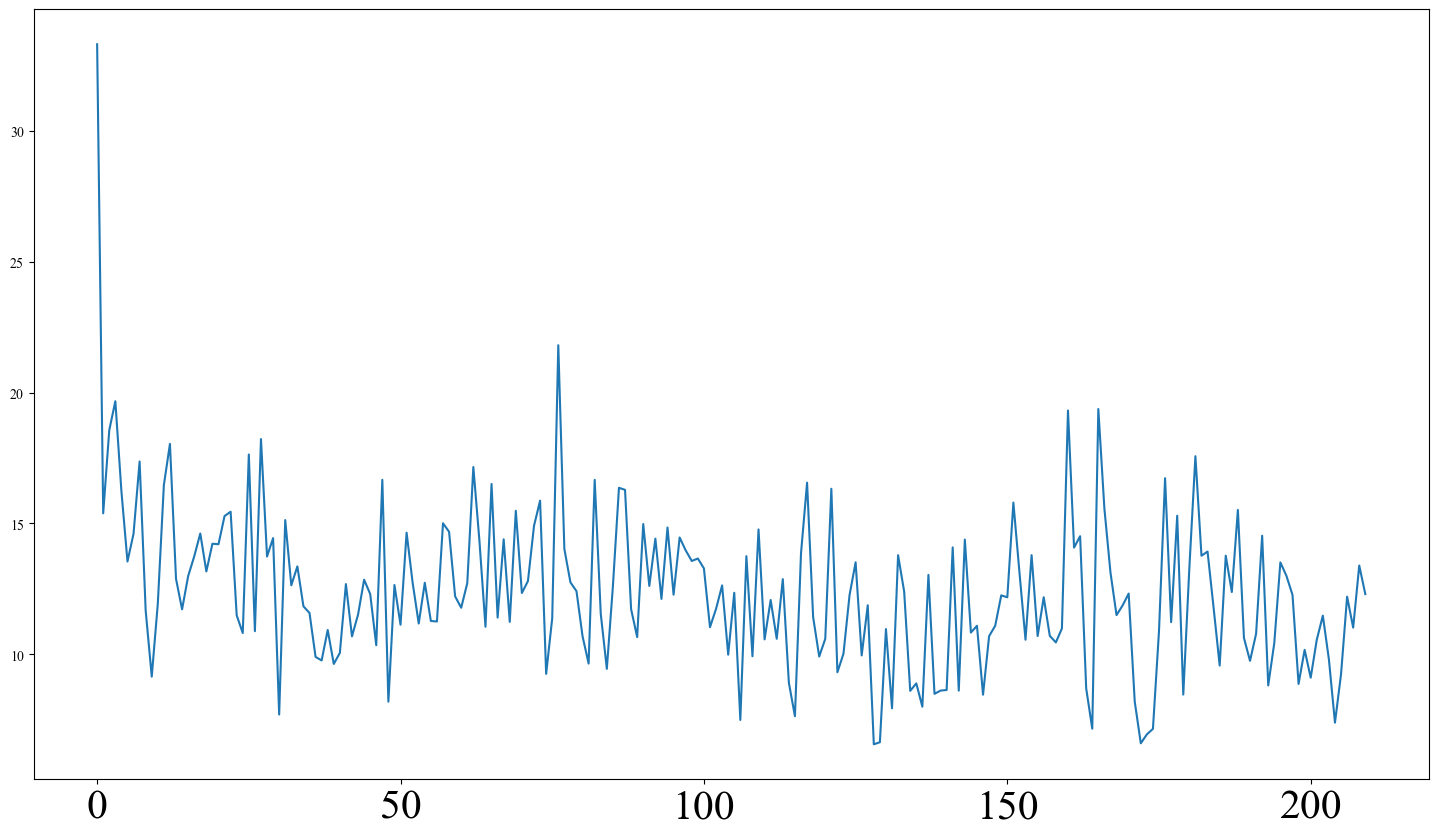

In [179]:
fig, ax = plt.subplots(figsize=(18, 10))
# ax.plot(np.array(Analytic_ws_online_continue['Gen_D_KL_Layer_0']))
ax.plot(np.array(Analytic_ws_online_continue['Recog_D_KL_Layer_0']))
plt.show()

In [180]:
# Analytic_ws_online.dtypes

In [181]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [182]:
np.save('Parameters_ws_online_continue',parameters)

In [183]:
Analytic_ws_online_continue.to_csv('Analytic_ws_online_continue.csv', index = False)

In [37]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data_dist D_KL: 9.5247 H(Y): 6.8079
Layer 0 Gen_dist D_KL: 0.4009 H(Y): 6.7567
Layer 1 Recognition Distribution D_KL: 0.123 H(Y): 2.7925 H(Y|X): 0.8023 I_XY: 1.9902
Layer 1 Generative  Distribution D_KL: 0.119 H(Y): 6.7567 H(Y|X): 4.689 I_XY: 2.0677
Layer 2 Recognition Distribution D_KL: 0.0003 H(Y): 0.0198 H(Y|X): 0.0183 I_XY: 0.0015
Layer 2 Generative  Distribution D_KL: 0.0004 H(Y): 2.9125 H(Y|X): 2.9114 I_XY: 0.0011
Layer 3 Recognition Distribution D_KL: 0.0002 H(Y): 0.097 H(Y|X): 0.0968 I_XY: 0.0002
Layer 3 Generative  Distribution D_KL: 0.0002 H(Y): 0.0141 H(Y|X): 0.0139 I_XY: 0.0002
Layer 4 Recognition Distribution D_KL: 0.0002 H(Y): 0.0109 H(Y|X): 0.0108 I_XY: 0.0001
Layer 4 Generative  Distribution D_KL: 0.0002 H(Y): 0.0975 H(Y|X): 0.0972 I_XY: 0.0003
Layer 4 Generative  Distribution D_KL: 0.0002 H(Y): 0.0068 H(Y|X): 0.0068 I_XY: 0.0


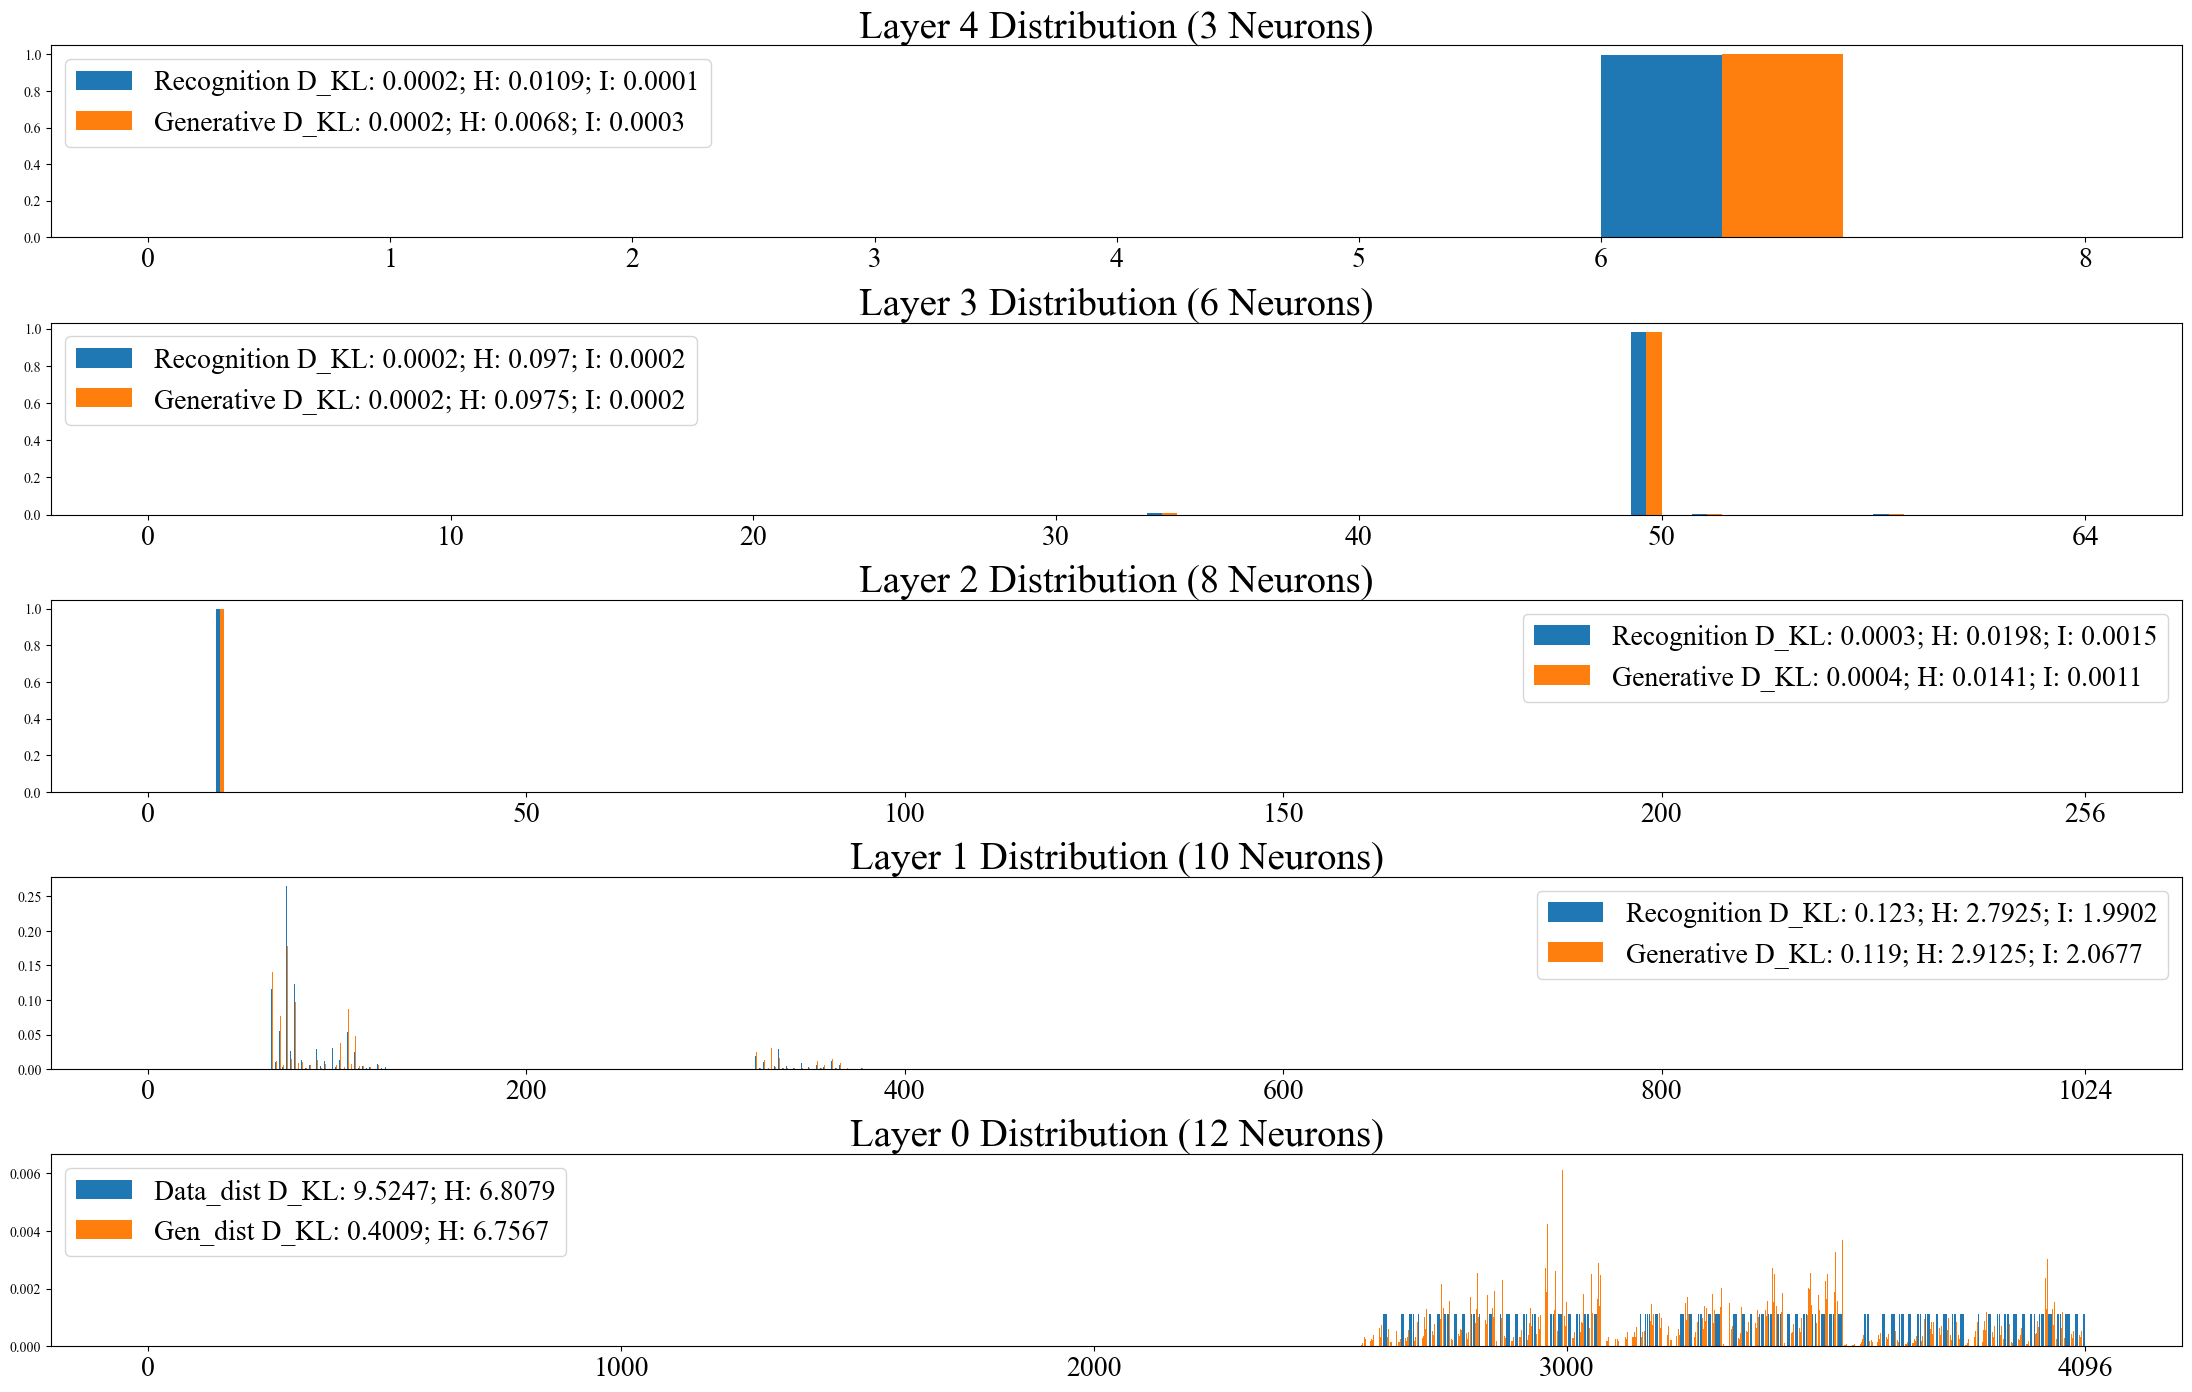

In [48]:
csfont = {'fontname':'Times New Roman'}
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rc('xtick', labelsize=20)

fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 14))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recognition D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" Distribution ("+ str(n_dz[i].item())+" Neurons)",fontsize=28)
    ax_ct[n_layer-2-i].legend(fontsize=20)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
plt.tight_layout(pad=1)    
plt.show()

Layer 0 Ground Truth D_KL: 9.5247 H(Y): 6.8079
Layer 0 Generative D_KL: 0.4009 H(Y): 6.7567
Layer 1 Recognition Distribution D_KL: 0.123 H(Y): 2.7925 H(Y|X): 0.8023 I_XY: 1.9902
Layer 1 Generative  Distribution D_KL: 0.119 H(Y): 6.7567 H(Y|X): 4.689 I_XY: 2.0677
Layer 2 Recognition Distribution D_KL: 0.0003 H(Y): 0.0198 H(Y|X): 0.0183 I_XY: 0.0015
Layer 2 Generative  Distribution D_KL: 0.0004 H(Y): 2.9125 H(Y|X): 2.9114 I_XY: 0.0011
Layer 3 Recognition Distribution D_KL: 0.0002 H(Y): 0.097 H(Y|X): 0.0968 I_XY: 0.0002
Layer 3 Generative  Distribution D_KL: 0.0002 H(Y): 0.0141 H(Y|X): 0.0139 I_XY: 0.0002
Layer 4 Recognition Distribution D_KL: 0.0002 H(Y): 0.0109 H(Y|X): 0.0108 I_XY: 0.0001
Layer 4 Generative  Distribution D_KL: 0.0002 H(Y): 0.0975 H(Y|X): 0.0972 I_XY: 0.0003
Layer 4 Generative  Distribution D_KL: 0.0002 H(Y): 0.0068 H(Y|X): 0.0068 I_XY: 0.0


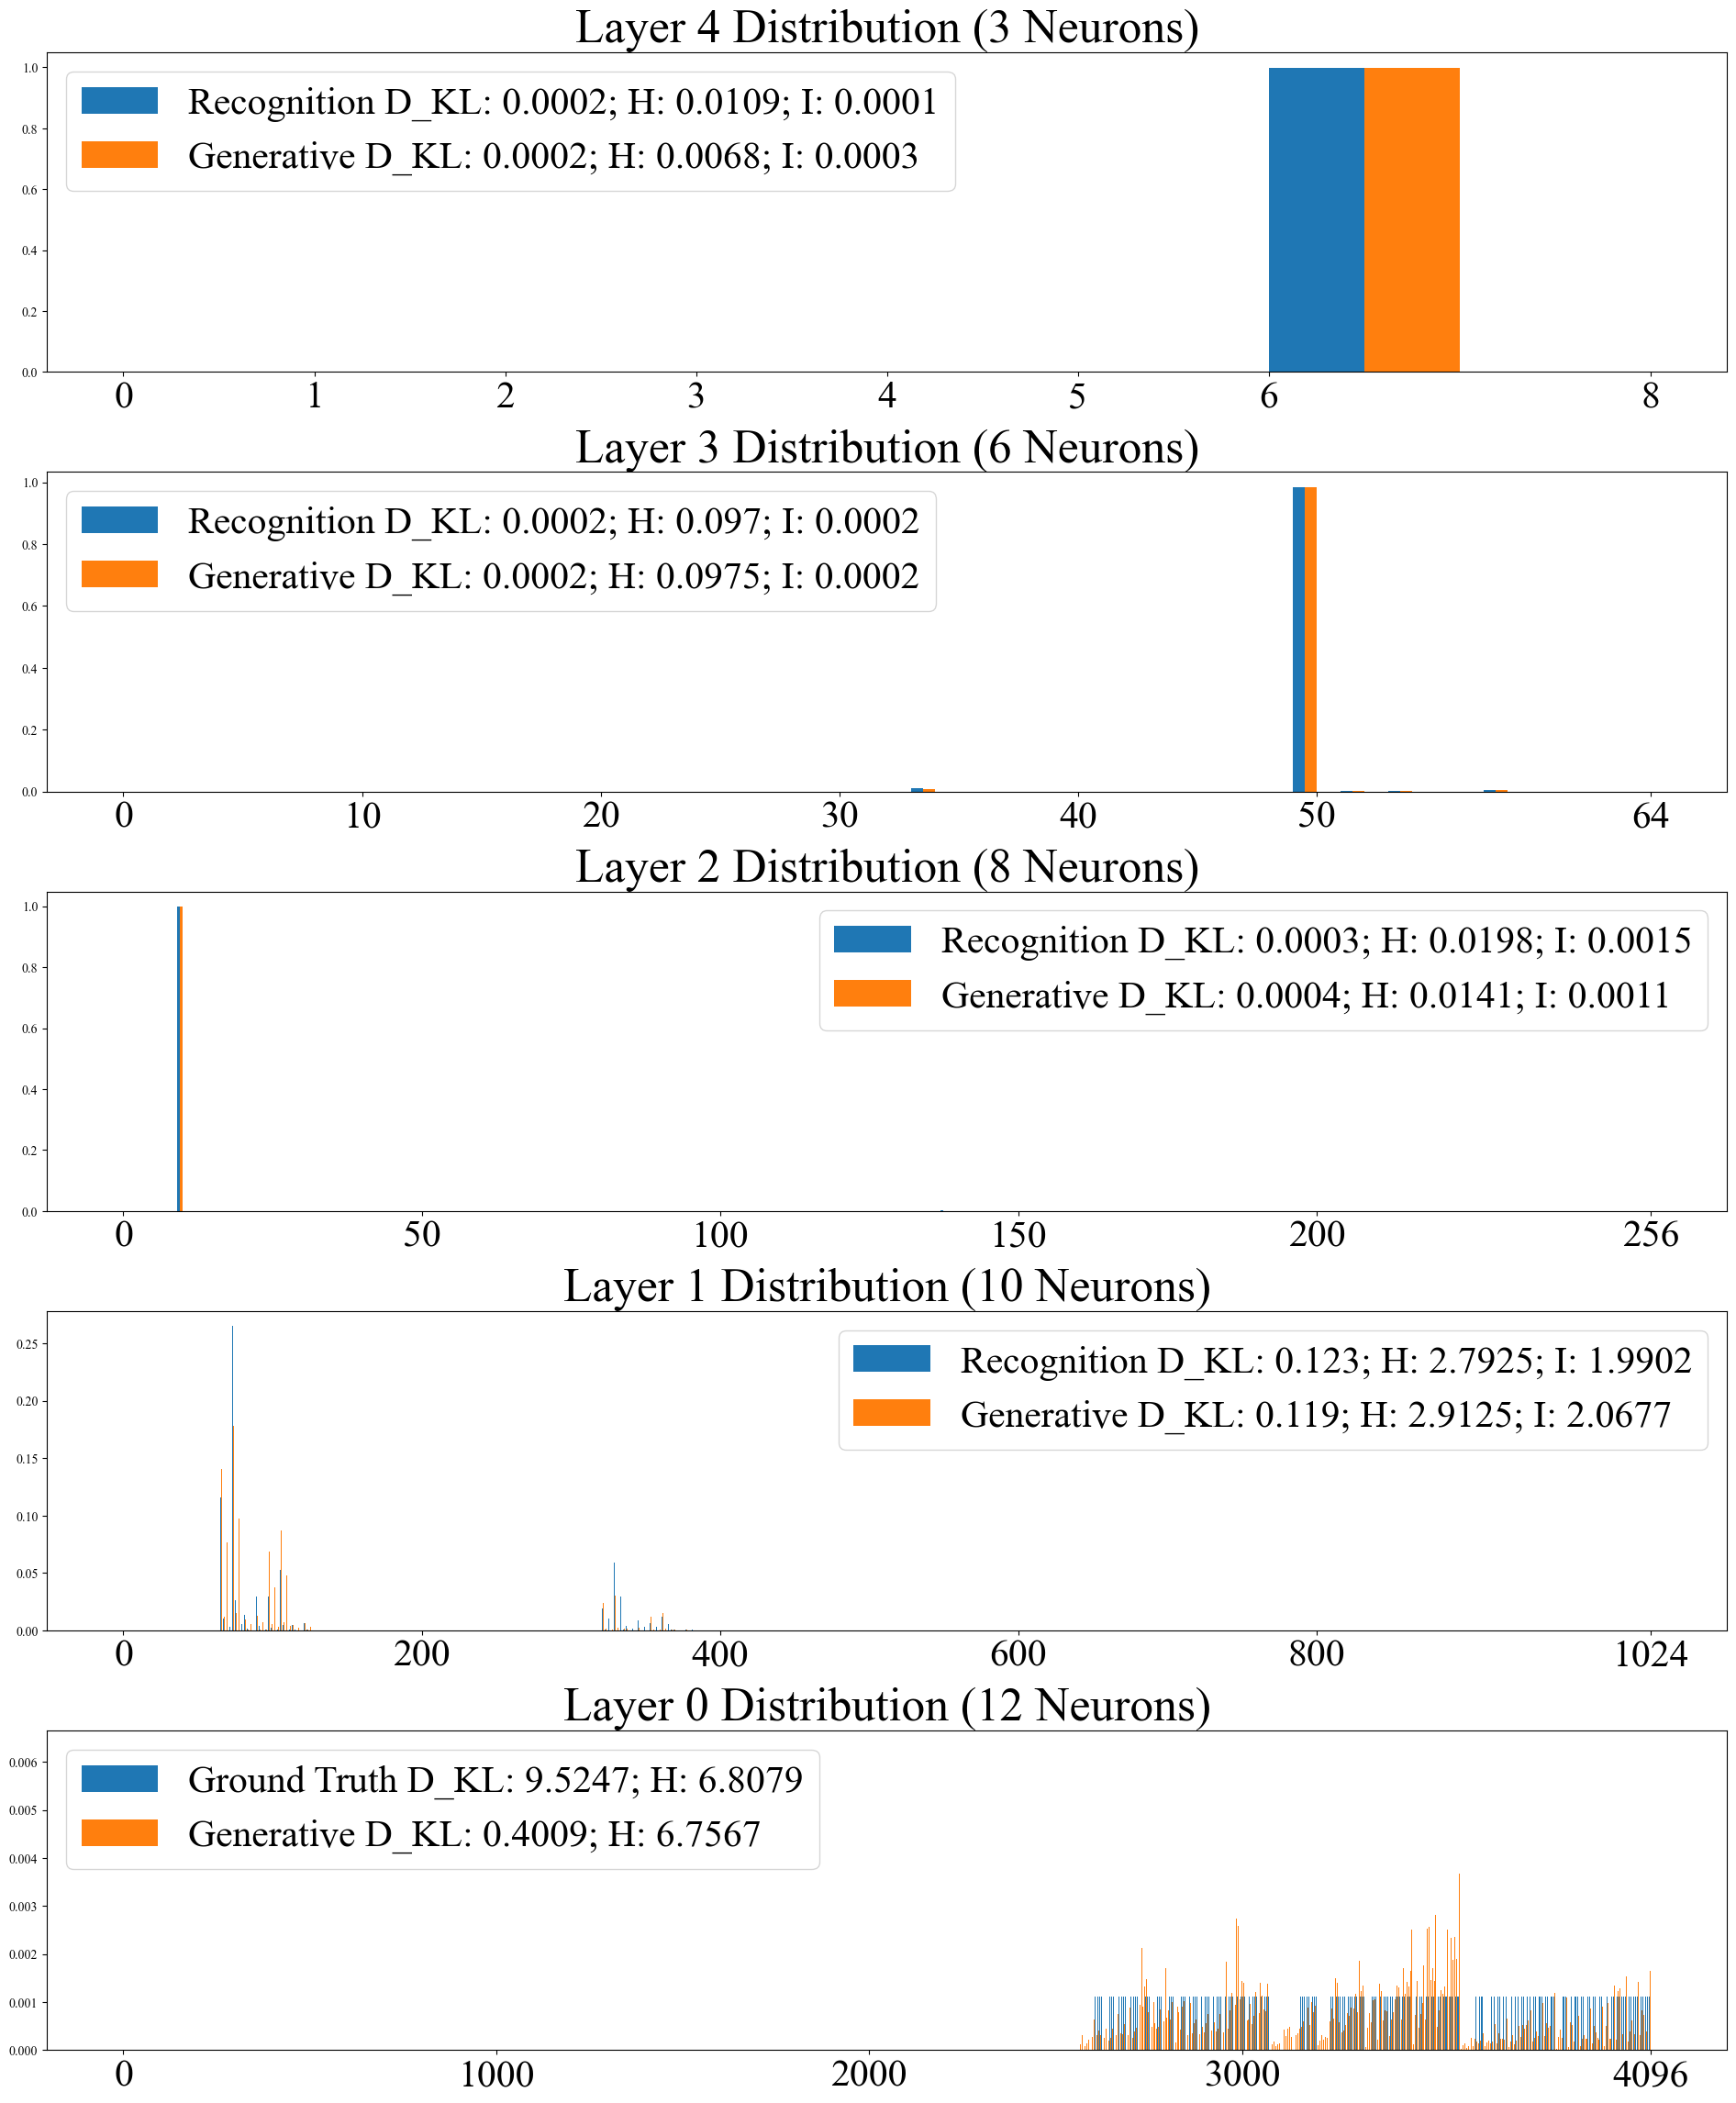

In [186]:
csfont = {'fontname':'Times New Roman'}
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rc('xtick', labelsize=30)
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(19, 23))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recognition D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(sleep_ct['Layer '+str(i)+': H_Y'].item(),4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Ground Truth D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Ground Truth D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Generative D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Generative D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" Distribution ("+ str(n_dz[i].item())+" Neurons)",fontsize=37)
    ax_ct[n_layer-2-i].legend(fontsize=30)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    
H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
I_s = H_Y_s - H_YX_s
D_KL_s = KL_divergence(dist_w,dist_s).item()
print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
  "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))    
plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: 0.1709 H(Y): 7.3327
Layer 0 Gen_dist D_KL: 0.1712 H(Y): 7.2975
Layer 1 Recognition Distribution D_KL: 0.0186 H(Y): 2.2092 H(Y|X): 0.1585 I_XY: 2.0507
Layer 1 Generative  Distribution D_KL: 0.0183 H(Y): 7.2975 H(Y|X): 4.8205 I_XY: 2.4771
Layer 2 Recognition Distribution D_KL: 0.0001 H(Y): 0.0061 H(Y|X): 0.0058 I_XY: 0.0003
Layer 2 Generative  Distribution D_KL: 0.0001 H(Y): 2.2439 H(Y|X): 2.2434 I_XY: 0.0005
Layer 3 Recognition Distribution D_KL: 0.0 H(Y): 0.0095 H(Y|X): 0.0094 I_XY: 0.0
Layer 3 Generative  Distribution D_KL: 0.0 H(Y): 0.009 H(Y|X): 0.009 I_XY: 0.0
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 0.0068 H(Y|X): 0.0068 I_XY: 0.0
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 0.0083 H(Y|X): 0.0083 I_XY: 0.0


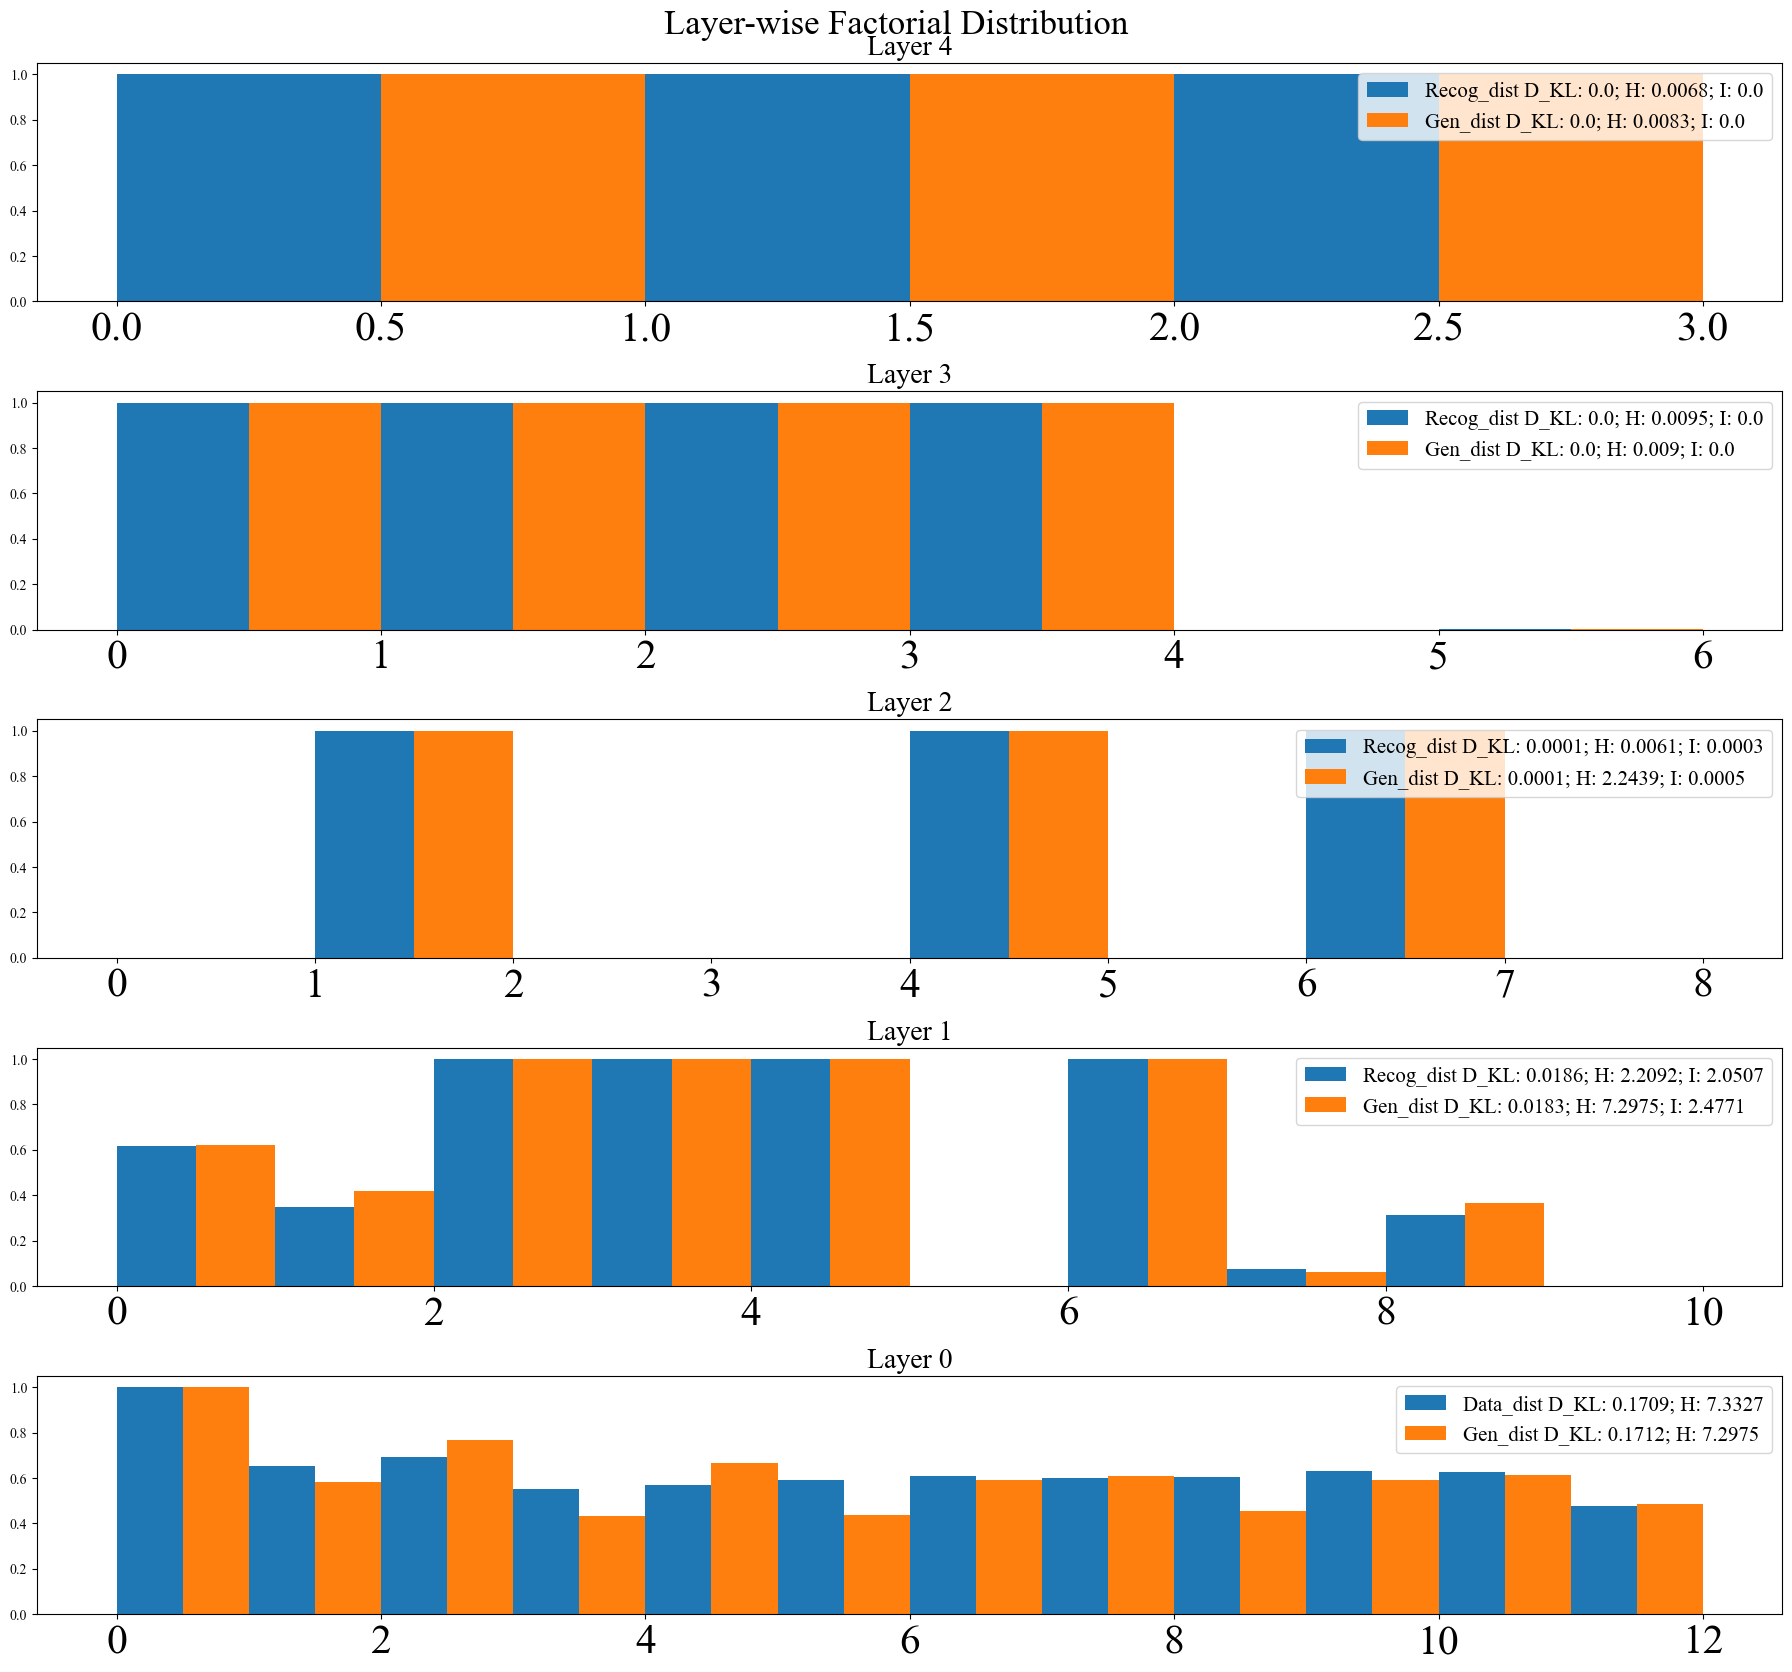

In [53]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
for i in range(n_layer-1):
    dist_s = sleep_ft['Layer '+str(i)+': dist']
    dist_w = wake_ft['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
           
        H_Y_s = sleep_ft['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ft['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)

plt.tight_layout(pad=1)    
plt.show()

In [199]:
def causal(n_dz, Theta, cause_layer, cause_indices, dev):
    """
    Arguments:
    n_dz -- structure of the Hemholtz machine, torch tensor of shape (n_layer, )
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    cause_layer -- layer number of the cause. Integer
    cause_indices -- the indices of the causes out of 2^n_x in its layer. Torch tensor of shape (n_cause, )
    dev -- torch device
    
    Returns:
    causal_dist -- dictionary of causal ditributions, of length cause_layer.
    """
    causal_dist = {}
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer], Theta["Theta_" + str(cause_layer) + str(cause_layer-1)], dev) # (2**n_z, 2**n_{z-1})
    dist_ct_pre = prob_ct[cause_indices,:]
    causal_dist['Layer '+str(cause_layer-1)+': dist'] = dist_ct_pre
    for i in range(1,cause_layer):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer-i], Theta["Theta_" + str(cause_layer-i) + str(cause_layer-i-1)],dev)
        causal_dist['Layer '+str(cause_layer-i-1)+': dist'], causal_dist['Layer '+str(cause_layer-i-1)+': H_Y'], \
        causal_dist['Layer '+str(cause_layer-i-1)+': H_YX'] = prob_matrix_ct(dist_ct_pre, prob_ct)
        dist_ct_pre = causal_dist['Layer '+str(cause_layer-i-1)+': dist']
    return causal_dist

In [200]:
torch.where(sleep_ct['Layer 1: dist'] > 0.05)[0]

tensor([578, 594, 595, 722, 850, 978])

In [201]:
cause_layer = 1
cause_indices = torch.where(sleep_ct['Layer 1: dist'] > 0.05)[0]
causal_dist = causal(n_dz, Theta, cause_layer, cause_indices, dev)
causal_dist

{'Layer 0: dist': tensor([[5.1445e-24, 8.6959e-24, 8.8220e-24,  ..., 6.2350e-06, 6.3254e-06,
          1.0692e-05],
         [1.3228e-26, 1.6381e-26, 1.4314e-26,  ..., 1.5929e-02, 1.3918e-02,
          1.7236e-02],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.3955e-06, 5.0111e-06,
          6.1701e-06],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5053e-10, 9.3710e-06,
          1.0436e-05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3691e-05, 1.2330e-05,
          9.1961e-06],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.2615e-14, 4.0366e-09,
          2.7074e-09]])}

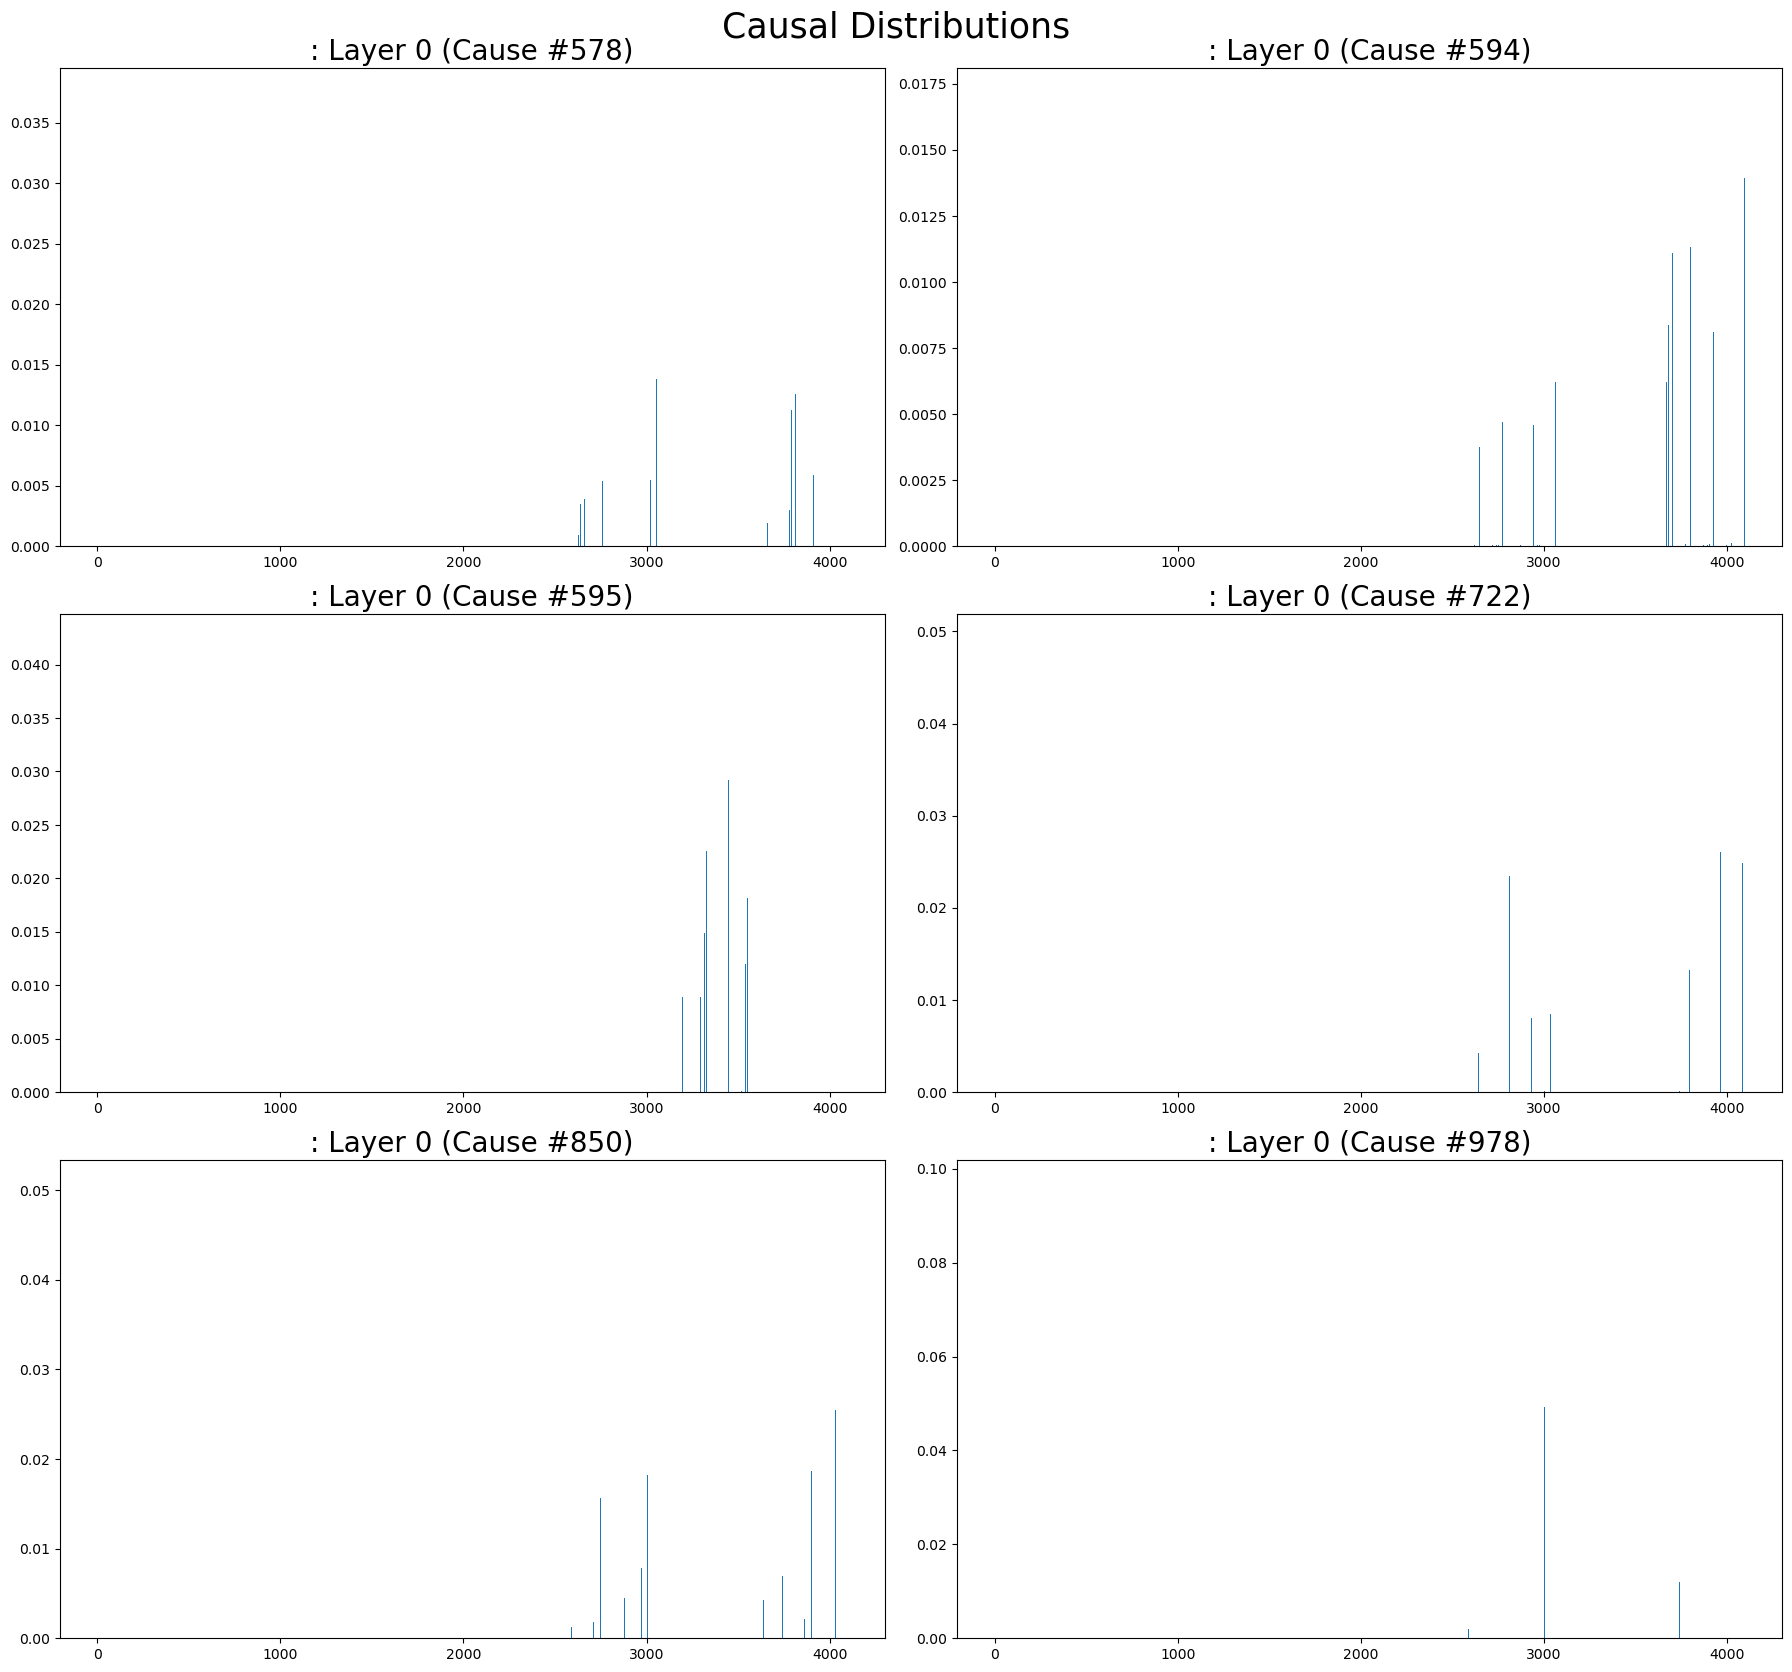

In [202]:
fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/2+0.5), 2, figsize=(18, 17))
fig.suptitle("Causal Distributions",fontsize=25)
for j in range(len(cause_indices)):
    row_ind = int(j/2)*cause_layer
    col_ind = j%2
    for i in range(cause_layer-1,-1,-1):
        dist = causal_dist['Layer '+str(i)+': dist'][j,:]
        ax[row_ind+cause_layer-1-i, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
                               label = "Data Distribution")
        ax[row_ind+cause_layer-1-i, col_ind].set_title("Layer "+str(i)+" (Cause #"+str(cause_indices[j].item())+")",fontsize=20)
    
#     H_Y = causal_dist['Layer '+str(i)+': H_Y'].item()
#     H_YX = causal_dist['Layer '+str(i)+': H_YX'].item()
#     I = H_Y - H_YX
#     ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
#                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
#                                str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
#     ax[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

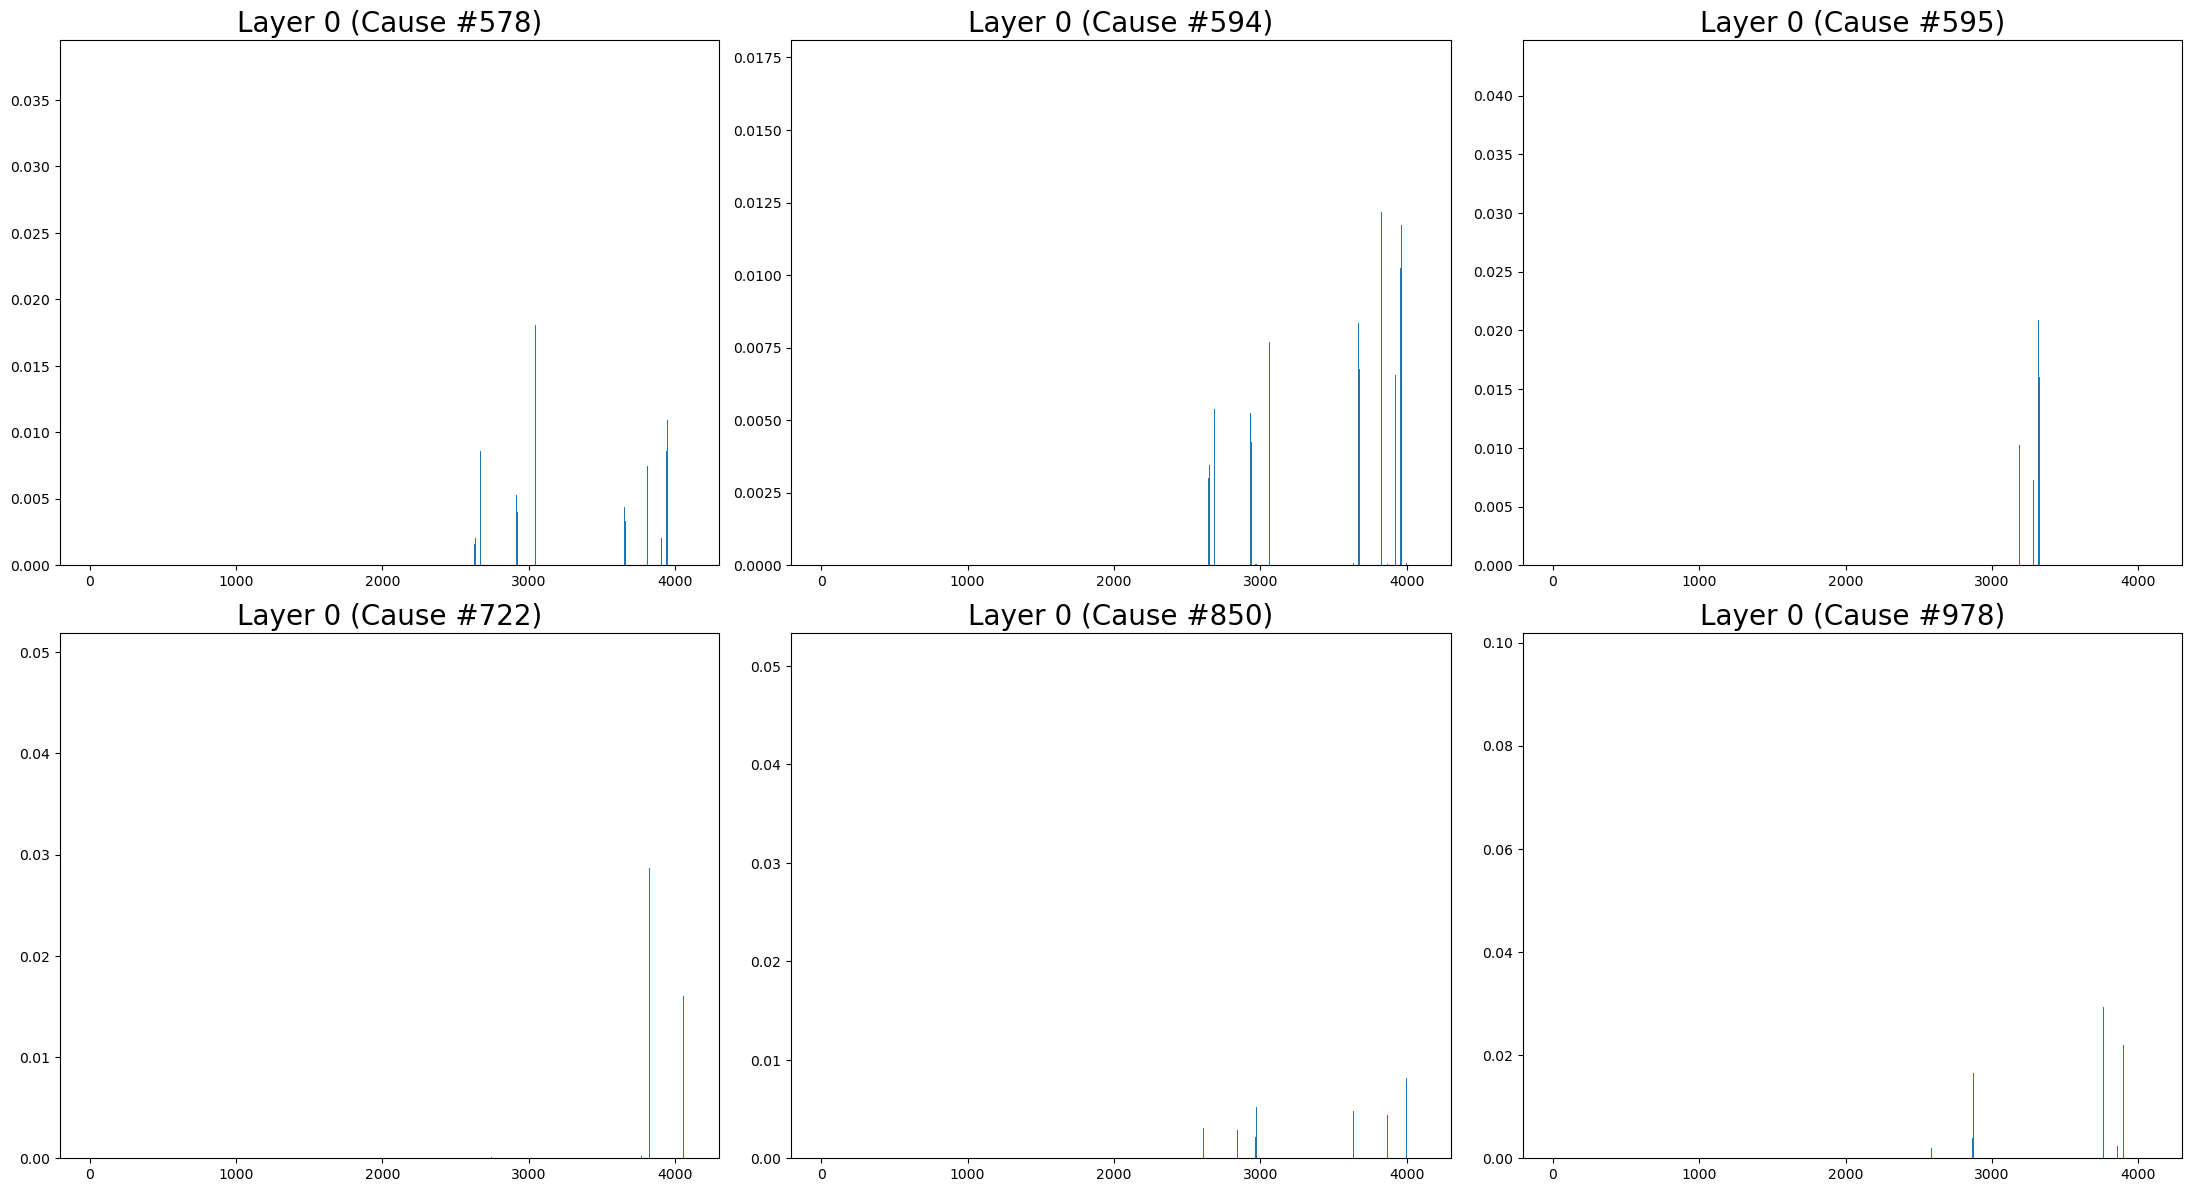

In [204]:
n_col = 3
fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/n_col+0.5), n_col, figsize=(22, 12))
# fig.suptitle("Causal Distributions",fontsize=25)
for j in range(len(cause_indices)):
    row_ind = int(j/n_col)*cause_layer
    col_ind = j%n_col
    for i in range(cause_layer-1,-1,-1):
        dist = causal_dist['Layer '+str(i)+': dist'][j,:]
        ax[row_ind+cause_layer-1-i, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
                               label = "Data Distribution")
        ax[row_ind+cause_layer-1-i, col_ind].set_title("Layer "+str(i)+" (Cause #"+str(cause_indices[j].item())+")",fontsize=20)
    
#     H_Y = causal_dist['Layer '+str(i)+': H_Y'].item()
#     H_YX = causal_dist['Layer '+str(i)+': H_YX'].item()
#     I = H_Y - H_YX
#     ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
#                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
#                                str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
#     ax[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

### Plot Analytic

In [188]:
Analytic_ws_online = pd.read_csv('Analytic_ws_online.csv', sep=",")
Analytic_ws_online

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0           0.549195          0.605361          0.602305          0.605072   
1           0.247130          0.140485          0.292811          0.228170   
2           0.208765          0.116884          0.190964          0.283248   
3           0.120577          0.086833          0.097020          0.084723   
4           0.107413          0.130565          0.081919          0.069047   
5           0.101646          0.032995          0.053908          0.032856   
6           0.092104          0.099257          0.054447          0.055602   
7           0.104955          0.114775          0.035502          0.028181   
8           0.085574          0.017484          0.034972          0.057759   
9           0.102654          0.016744          0.046859          0.113483   
10          0.048808          0.076215          0.037040          0.104087   
11          0.042188          0.073980          0.078447          0.064207   
12          0.041930          0.037594          0.175664          0.073402   
13          0.036384          0.067067          0.111265          0.024693   
14          0.043988          0.058469          0.032961          0.171641   
15          0.071364          0.059315          0.031438          0.026041   
16          0.038147          0.033740          0.027123          0.018729   
17          0.032257          0.098565          0.025683          0.038827   
18          0.038001          0.065386          0.019567          0.081627   
19          0.062263          0.074889          0.098646          0.040388   
20          0.045273          0.026735          0.017913          0.012981   
21          0.032325          0.014925          0.028447          0.020625   
22          0.051500          0.013237          0.028431          0.017887   
23          0.042869          0.024118          0.018024          0.013633   
24          0.062926          0.036029          0.012710          0.013420   
25          0.038477          0.012195          0.009415          0.022800   
26          0.067314          0.012821          0.011845          0.011990   
27          0.053344          0.012650          0.016681          0.024536   
28          0.039859          0.068511          0.013531          0.012964   
29          0.067761          0.026127          0.025386          0.012989   
30          0.100556          0.051426          0.022353          0.006547   
31          0.057945          0.013846          0.030612          0.006139   
32          0.073480          0.009340          0.013665          0.006390   
33          0.061145          0.010080          0.020461          0.010890   
34          0.057243          0.001832          0.018436          0.006864   
35          0.122582          0.007146          0.017915          0.003253   
36          0.131615          0.007733          0.015000          0.010627   
37          0.082704          0.006973          0.010611          0.000658   
38          0.048143          0.010464          0.013173          0.003665   
39          0.057701          0.011009          0.008486          0.003271   
40          0.060796          0.021362          0.014543          0.010405   
41          0.053149          0.015102          0.008875          0.006190   
42          0.077328          0.028967          0.015222          0.006163   
43          0.039187          0.025989          0.023160          0.003290   
44          0.028577          0.028722          0.040583          0.008116   
45          0.033003          0.020108          0.018605          0.000494   
46          0.043447          0.021662          0.011825          0.008757   
47          0.031109          0.025863          0.016625          0.000444   
48          0.060851          0.041906          0.024772          0.003371   
49          0.051012          0.019542          0.044022          0.004926   
50          0.041263      

In [152]:
Analytic_ws_gen_batch = pd.read_csv('Analytic_ws_gen_batch.csv', sep=",")
Analytic_ws_gen_batch

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0            0.572849          0.585969          0.621368          0.619785   
1            0.237624          0.105303          0.307505          0.140417   
2            0.178891          0.068987          0.072189          0.210632   
3            0.129345          0.031113          0.029259          0.017588   
4            0.127586          0.061613          0.020813          0.021507   
..                ...               ...               ...               ...   
116          0.082015          0.004867          0.001255          0.001722   
117          0.042792          0.001998          0.000610          0.001454   
118          0.041648          0.000922          0.001501          0.001266   
119          0.040790          0.000600          0.000836          0.001235   
120          0.046976          0.000552          0.000672          0.000899   

     Theta_Loss_Layer_0  Theta_Loss_Layer_1  Theta_Loss_Layer_2  \
0              0.632842            0.598535            0.599493   
1              0.414395            0.441840            0.116593   
2              0.399434            0.402951            0.088752   
3              0.443006            0.311648            0.036083   
4              0.418018            0.332086            0.076833   
..                  ...                 ...                 ...   
116            0.370837            0.356350            0.011435   
117            0.382960            0.309532            0.004146   
118            0.384542            0.301525            0.000098   
119            0.391275            0.301008            0.001413   
120            0.384785            0.309925            0.001375   

     Theta_Loss_Layer_3  Theta_Loss_Layer_4  Recog_D_KL_Layer_0  ...  \
0              0.640262            0.641000           27.813496  ...   
1              0.322713            0.166652           12.659010  ...   
2              0.071626            0.231786            6.715577  ...   
3              0.030758            0.015112           13.696703  ...   
4              0.016788            0.017045            9.596713  ...   
..                  ...                 ...                 ...  ...   
116            0.000157            0.000152            9.180554  ...   
117            0.000085            0.000201            8.304753  ...   
118            0.000156            0.006824            6.708382  ...   
119            0.000085            0.000104            8.861288  ...   
120            0.000066            0.000094            9.130406  ...   

     Recog_D_KL_Layer_3  Gen_H_Layer_3  Gen_I_Layer_3  Gen_D_KL_Layer_3  \
0              0.034433       3.789535       0.095160          0.033166   
1              0.007220       2.036092       0.076201          0.007088   
2              0.002326       0.359958       0.037284          0.002505   
3              0.000545       0.203194       0.002797          0.000538   
4              0.000356       0.112625       0.002019          0.000389   
..                  ...            ...            ...               ...   
116            0.000019       0.008331       0.000052          0.000018   
117            0.000012       0.005099       0.000038          0.000017   
118            0.000016       0.007610       0.000043          0.000022   
119            0.000006       0.005032       0.000031          0.000003   
120            0.000018       0.004145       0.000026          0.000018   

     Recog_H_Layer_4  Recog_I_Layer_4  Recog_D_KL_Layer_4  Gen_H_Layer_4  \
0           1.835547         0.053957            0.005801       1.776885   
1           0.441819         0.075975            0.000931       0.451441   
2           0.672926         0.044275            0.003512       0.646119   
3           0.052699         0.002256            0.000052       0.055237   
4           0.067643         0.001717            0.000038       0.064119   
..               ...         

In [8]:
x = np.arange(len(Analytic_ws_online))

In [9]:
y_online = np.array(Analytic_ws_online['Gen_D_KL_Layer_0']) + np.array(Analytic_ws_online['Recog_D_KL_Layer_0'])/np.array(Analytic_ws_online['Recog_D_KL_Layer_0']).mean()*np.array(Analytic_ws_online['Gen_D_KL_Layer_0']).mean()

In [10]:
y_gen_batch = np.array(Analytic_ws_gen_batch['Gen_D_KL_Layer_0']) + np.array(Analytic_ws_gen_batch['Recog_D_KL_Layer_0'])/np.array(Analytic_ws_gen_batch['Recog_D_KL_Layer_0']).mean()*np.array(Analytic_ws_gen_batch['Gen_D_KL_Layer_0']).mean()

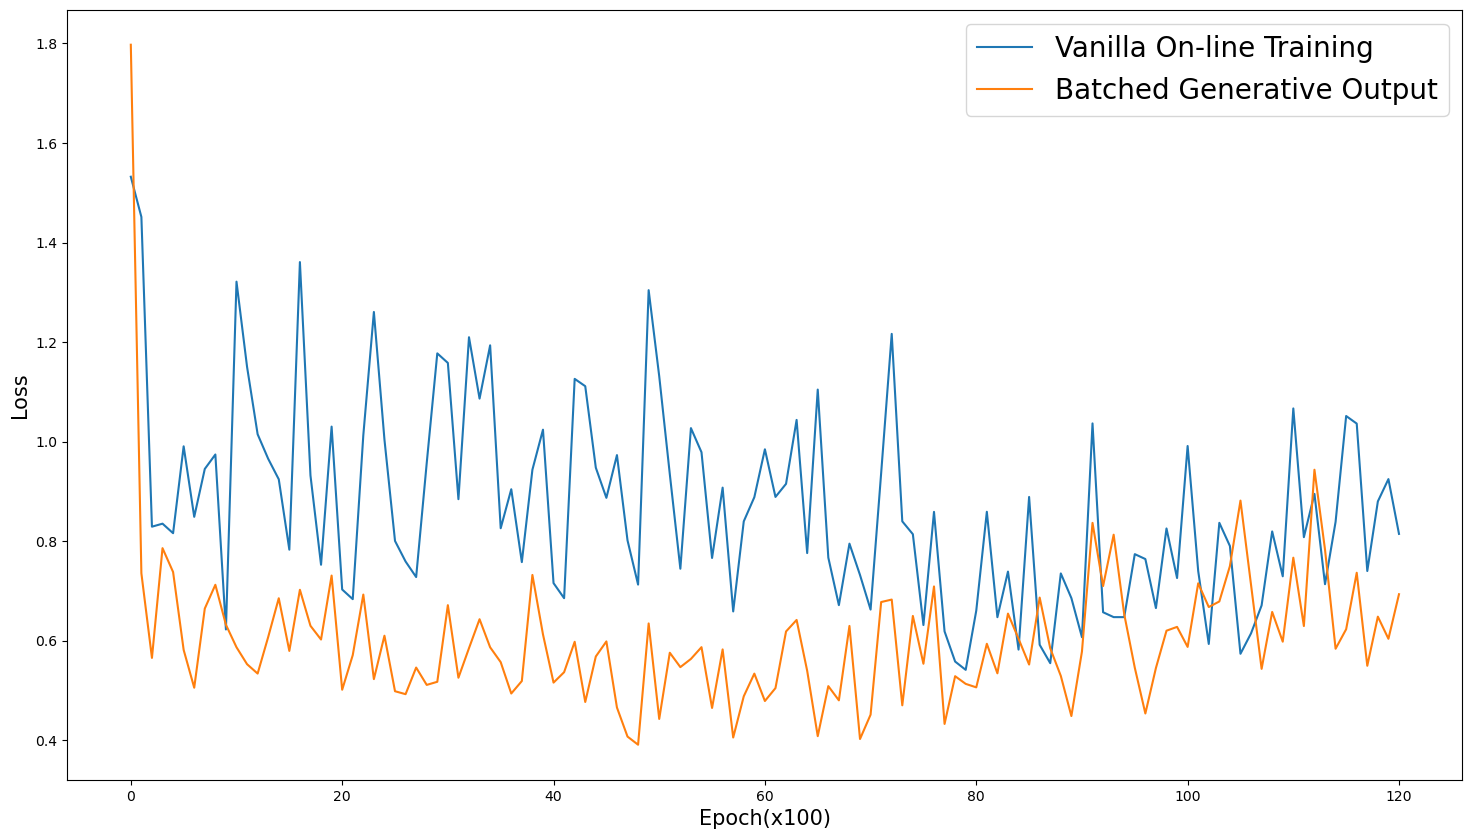

In [141]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, y_online,label="Vanilla On-line Training")
ax.plot(x, y_gen_batch, label="Batched Generative Output")
ax.legend(fontsize=20)
ax.set_xlabel("Epoch(x100)",fontsize=15)
ax.set_ylabel("Loss",fontsize=15)
plt.show()

In [37]:
x1 = np.arange(len(Analytic_ws_online))
x2 = np.arange(len(Analytic_ws_online)-1,len(Analytic_ws_online_continue))
factor = np.array(Analytic_ws_online['Recog_D_KL_Layer_0']).mean()/np.array(Analytic_ws_online['Gen_D_KL_Layer_0']).mean()

In [38]:
y_online = np.array(Analytic_ws_online['Gen_D_KL_Layer_0']) + np.array(Analytic_ws_online['Recog_D_KL_Layer_0'])/factor

In [39]:
y_online_continue = np.array(Analytic_ws_online_continue['Gen_D_KL_Layer_0']) + np.array(Analytic_ws_online_continue['Recog_D_KL_Layer_0'])/factor

In [40]:
y_mi = np.array(Analytic_ws_online_MI['Gen_D_KL_Layer_0']) + np.array(Analytic_ws_online_MI['Recog_D_KL_Layer_0'])/factor

In [50]:
y_perturb = np.array(Analytic_ws_online_perturb['Gen_D_KL_Layer_0']) + np.array(Analytic_ws_online_perturb['Recog_D_KL_Layer_0'])/factor

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x1, y_online,color='black',label="Pre-train with Wake-Sleep Algorithm")
ax.plot(x2, y_online_continue[120:], label="Continue with Vanilla Wake-Sleep")
ax.plot(x2, y_mi[120:], label="Continue with Wake-Sleep + MIM")
ax.plot(x2, y_perturb[120:], label="Continue with Wake-Sleep + Random Perturbation")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch(x10)",fontsize=15)
ax.set_ylabel("Loss",fontsize=15)
plt.show()

In [80]:
Analytic_ws_online['Index'] = Analytic_ws_online.index

D:\Program\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


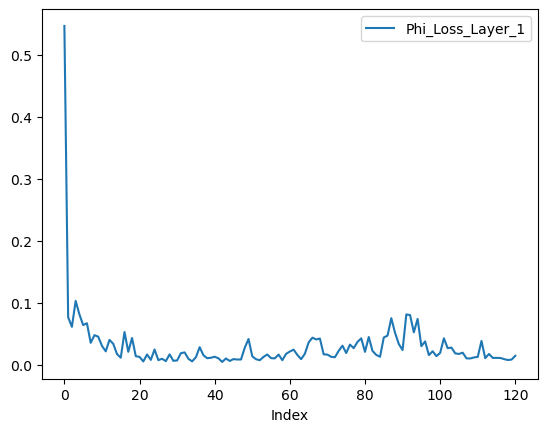

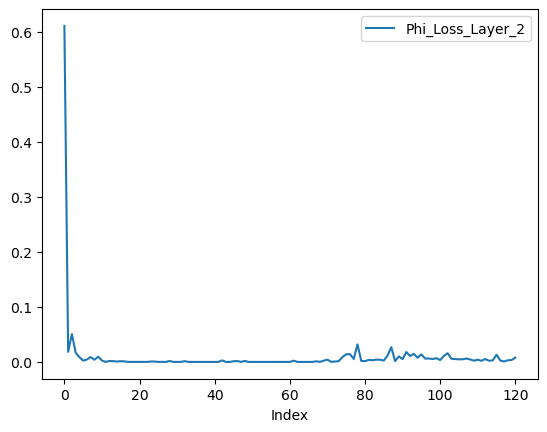

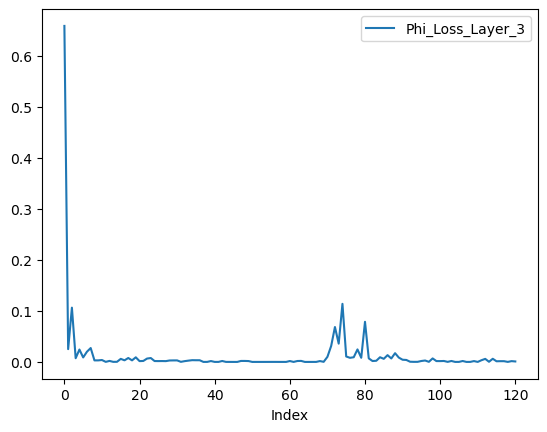

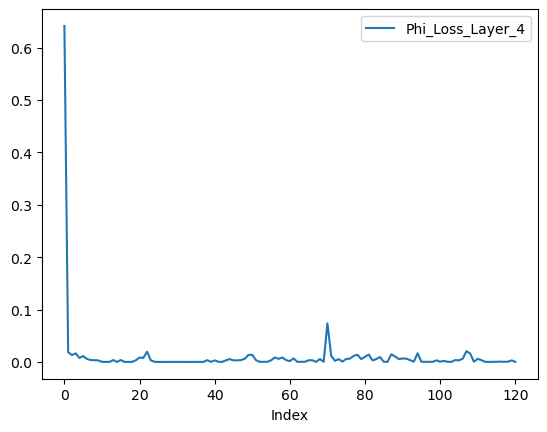

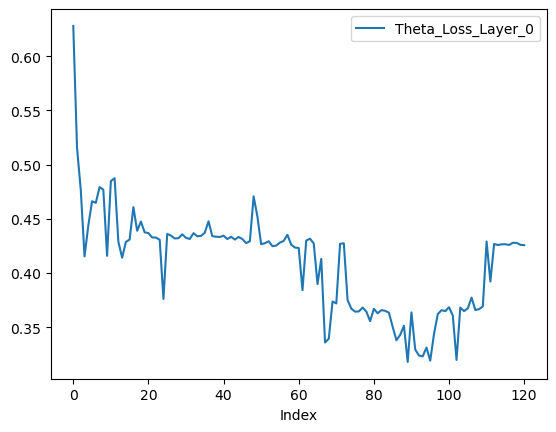

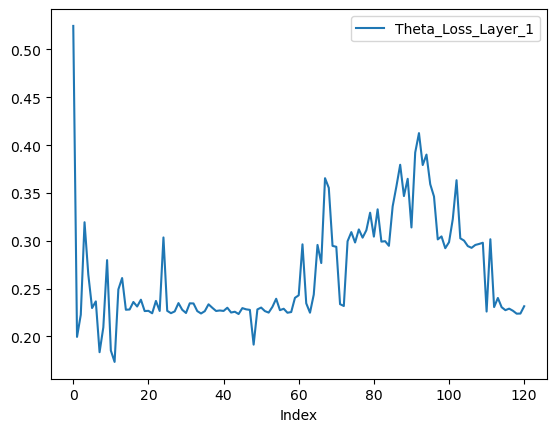

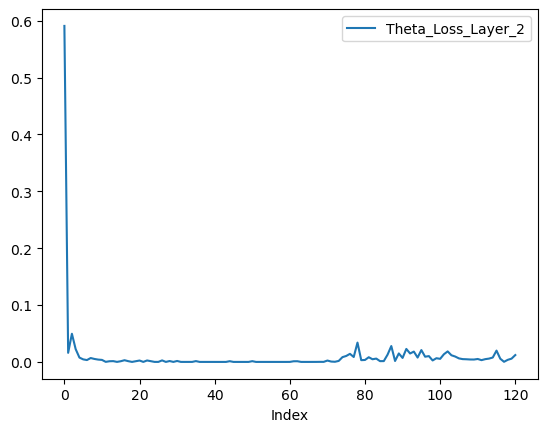

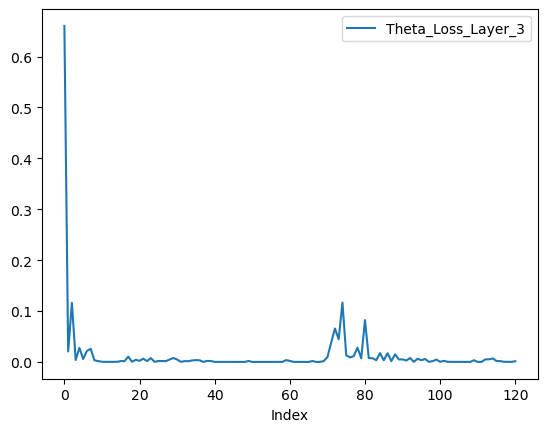

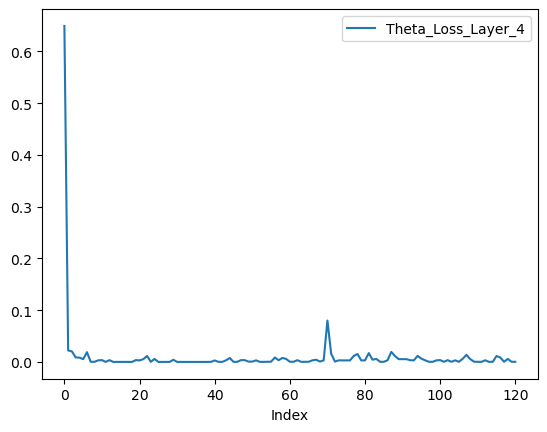

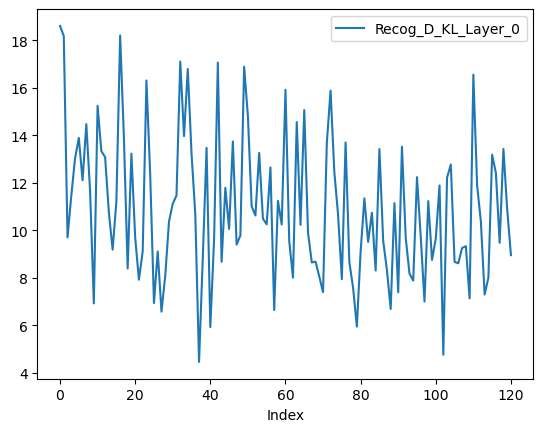

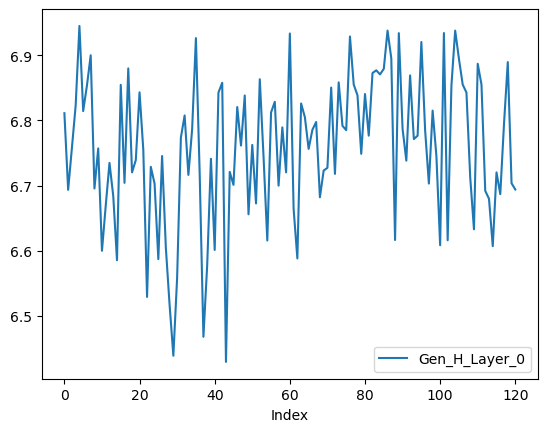

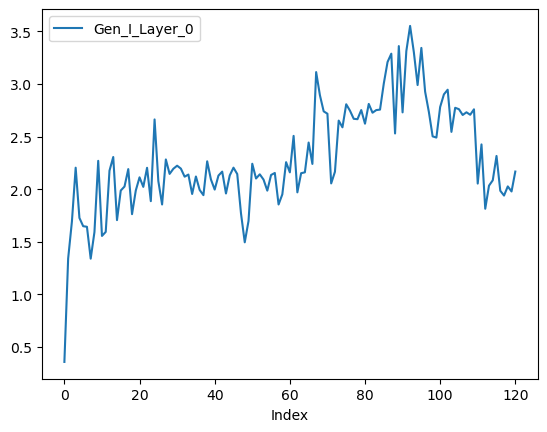

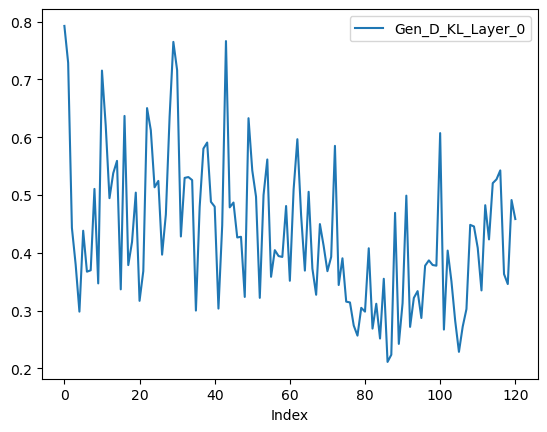

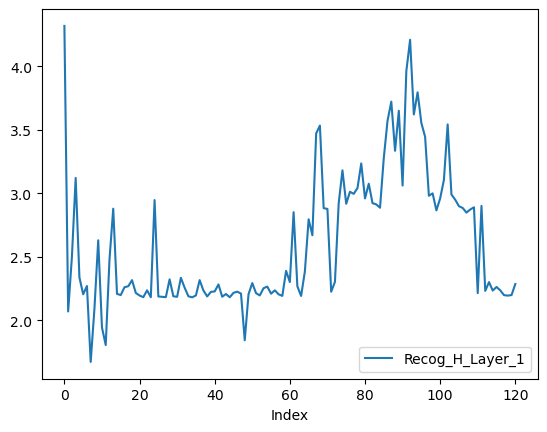

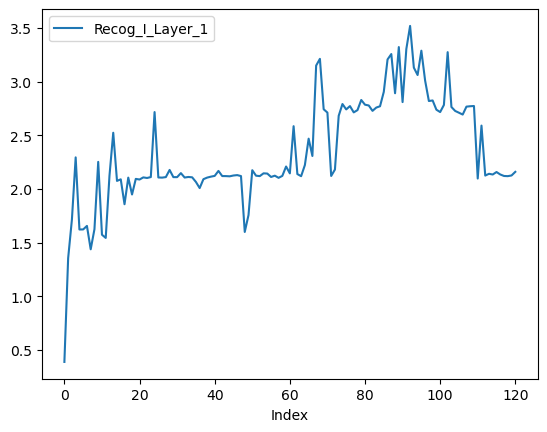

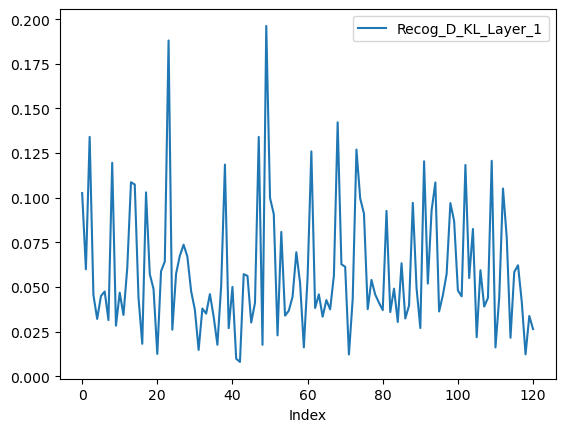

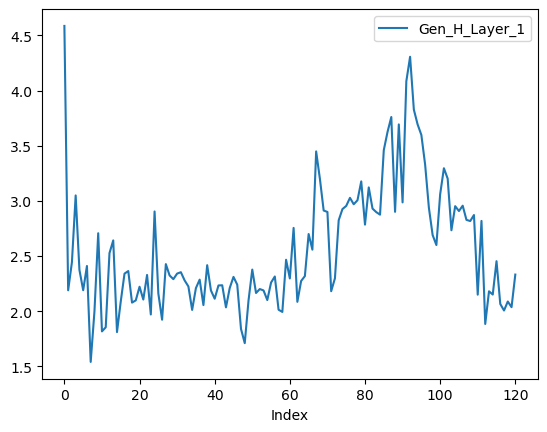

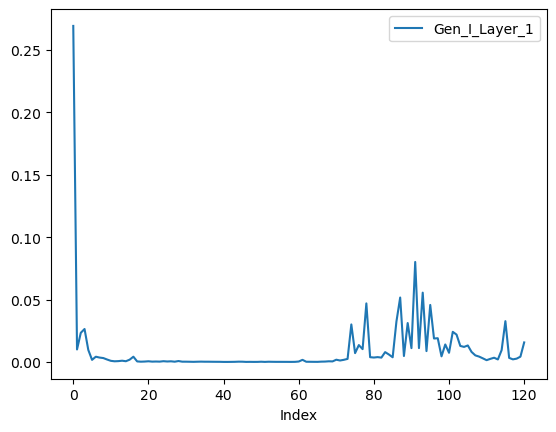

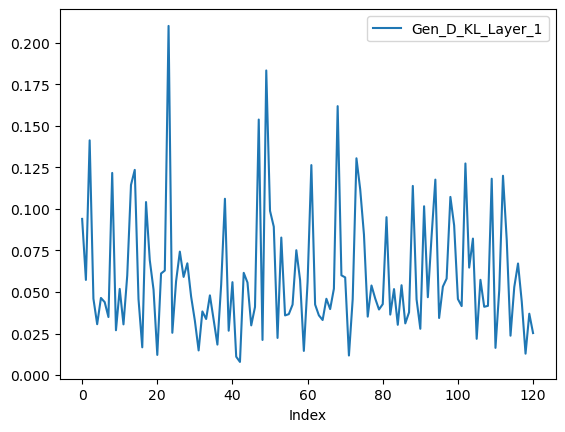

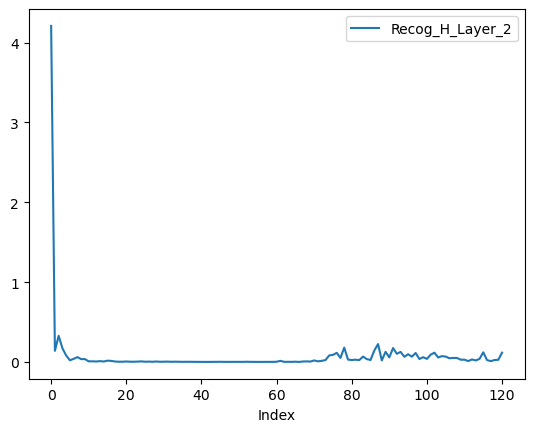

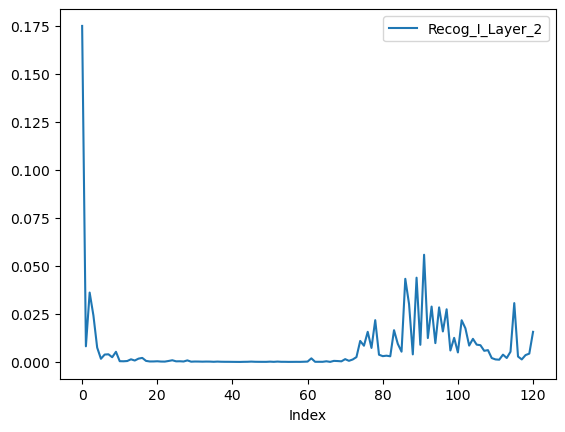

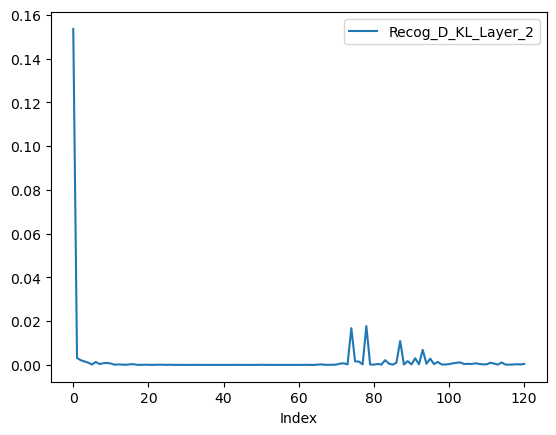

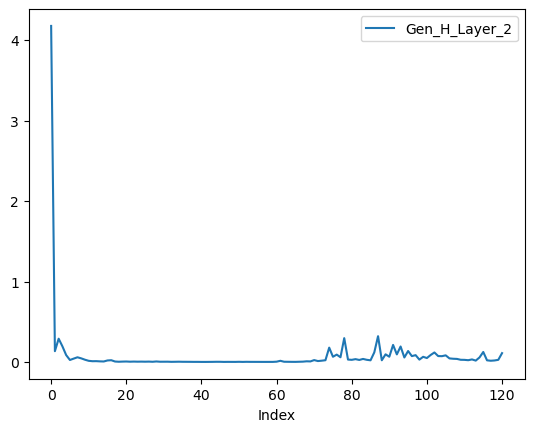

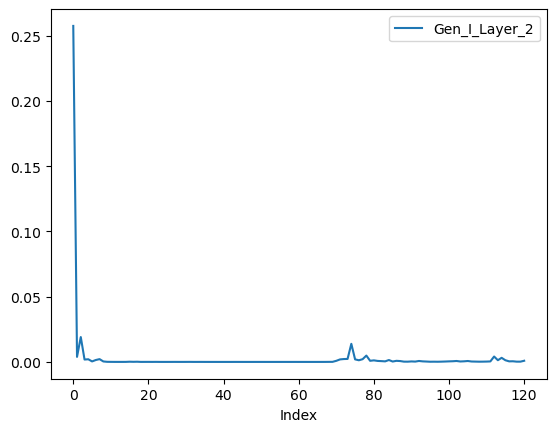

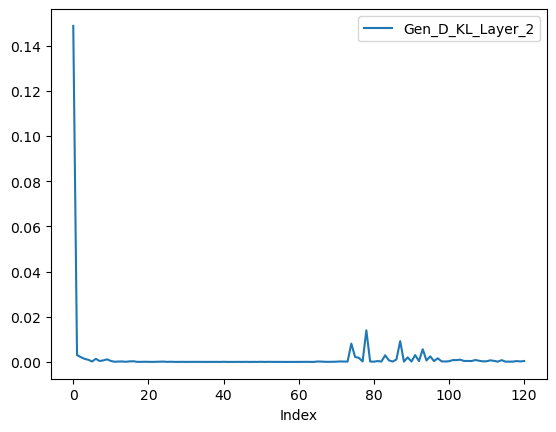

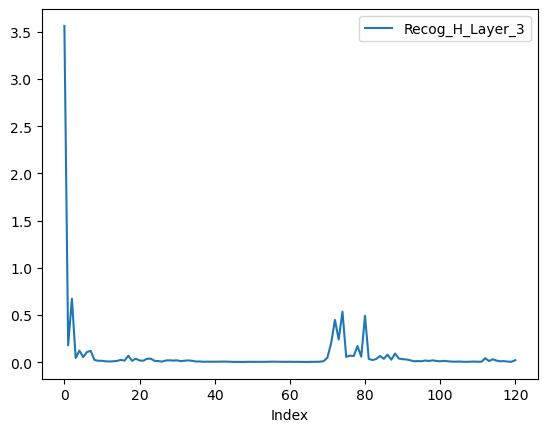

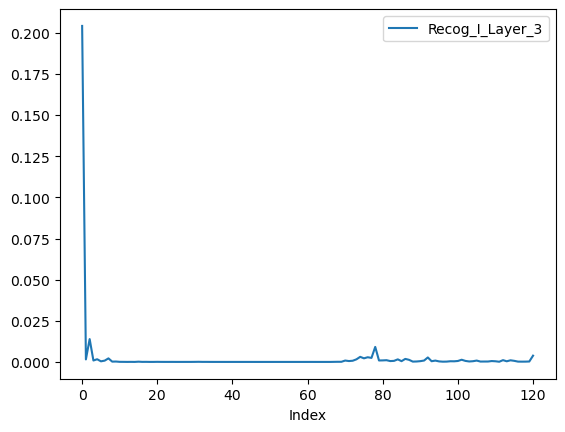

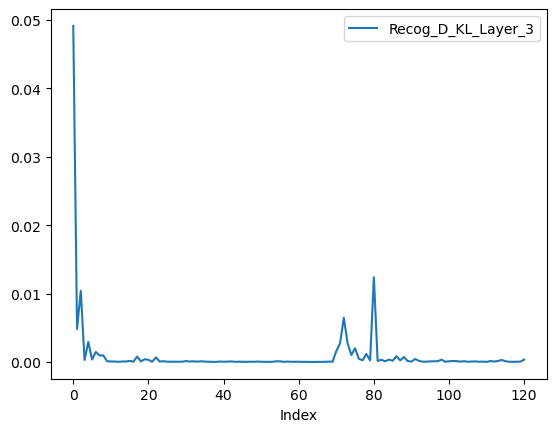

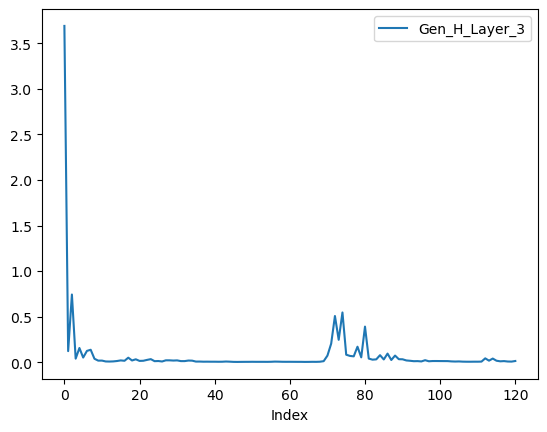

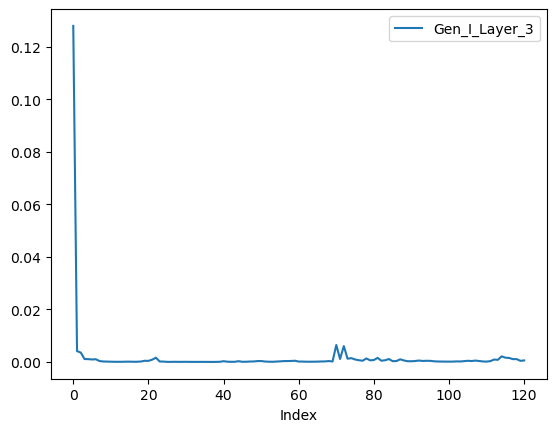

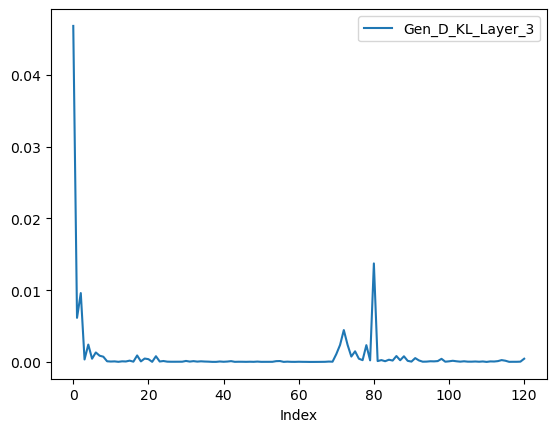

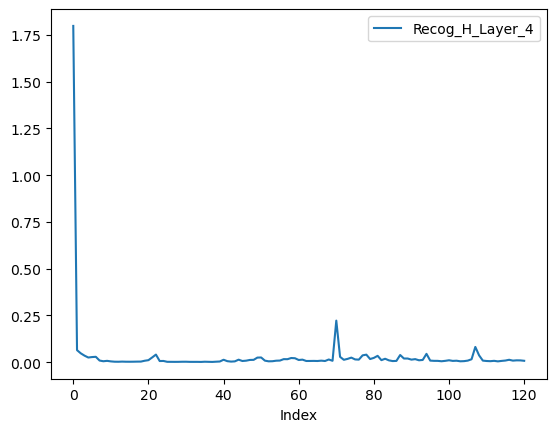

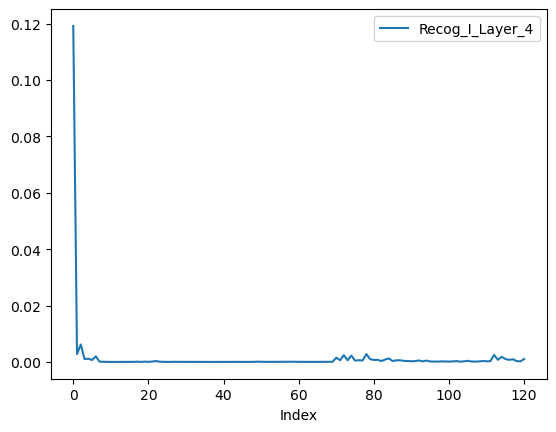

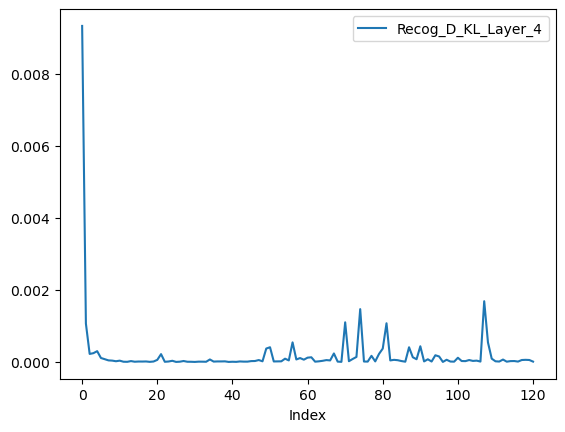

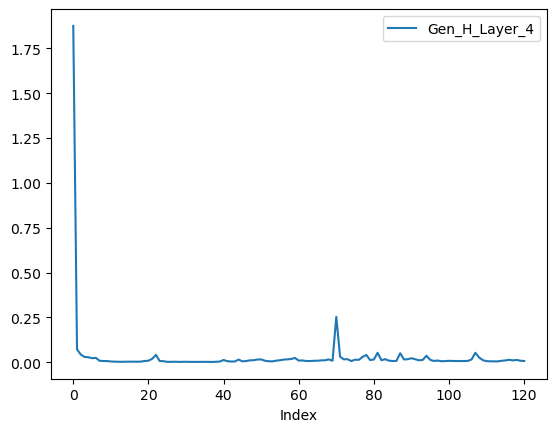

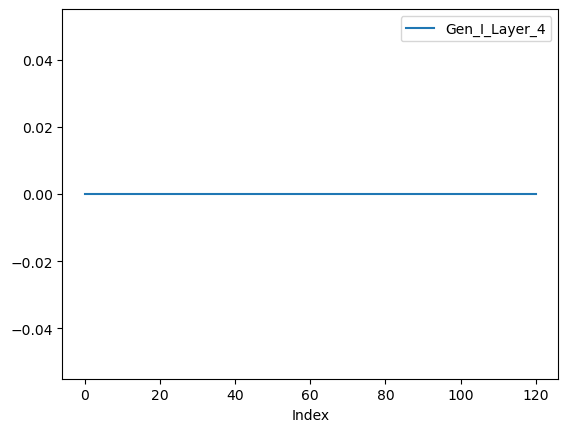

In [86]:
for i in range(len(col_list)):
    Analytic_ws_online.plot(x='Index',y=col_list[i],kind='line',legend=True)
plt.close()

In [144]:
Analytic_ws_online = Analytic_ws_online_continue
x = np.arange(len(Analytic_ws_online))

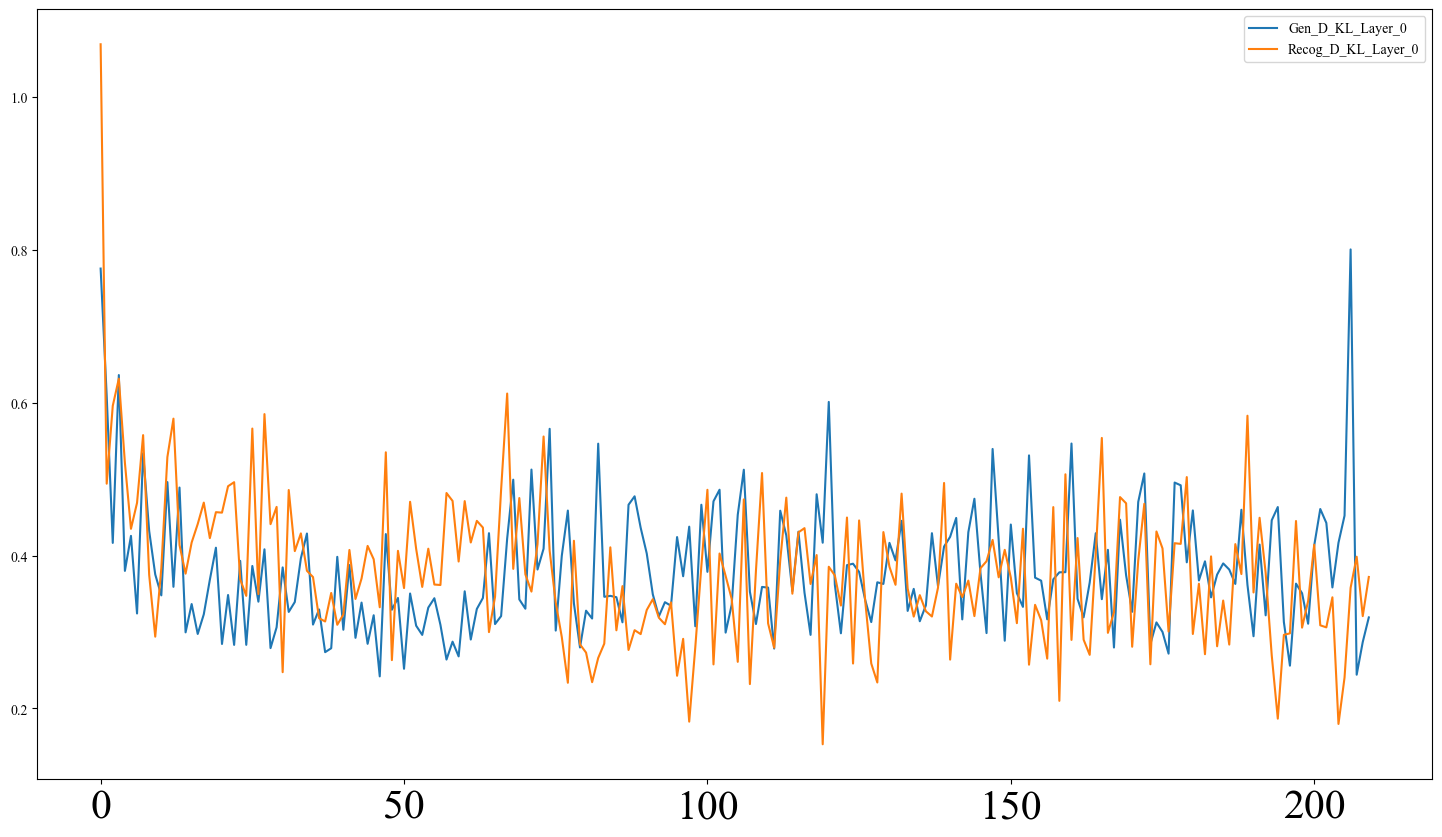

In [145]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_online['Gen_D_KL_Layer_'+str(0)]),label = 'Gen_D_KL_Layer_'+str(0))
ax.plot(x, np.array(Analytic_ws_online['Recog_D_KL_Layer_'+str(0)])/np.array(Analytic_ws_online['Recog_D_KL_Layer_'+str(0)]).mean()*np.array(Analytic_ws_online['Gen_D_KL_Layer_'+str(0)]).mean(),label = 'Recog_D_KL_Layer_'+str(0))
# ax.plot(x, np.array(Analytic_ws_online['Recog_D_KL_Layer_'+str(0)]),label = 'Recog_D_KL_Layer_'+str(0))
ax.legend()
plt.show()

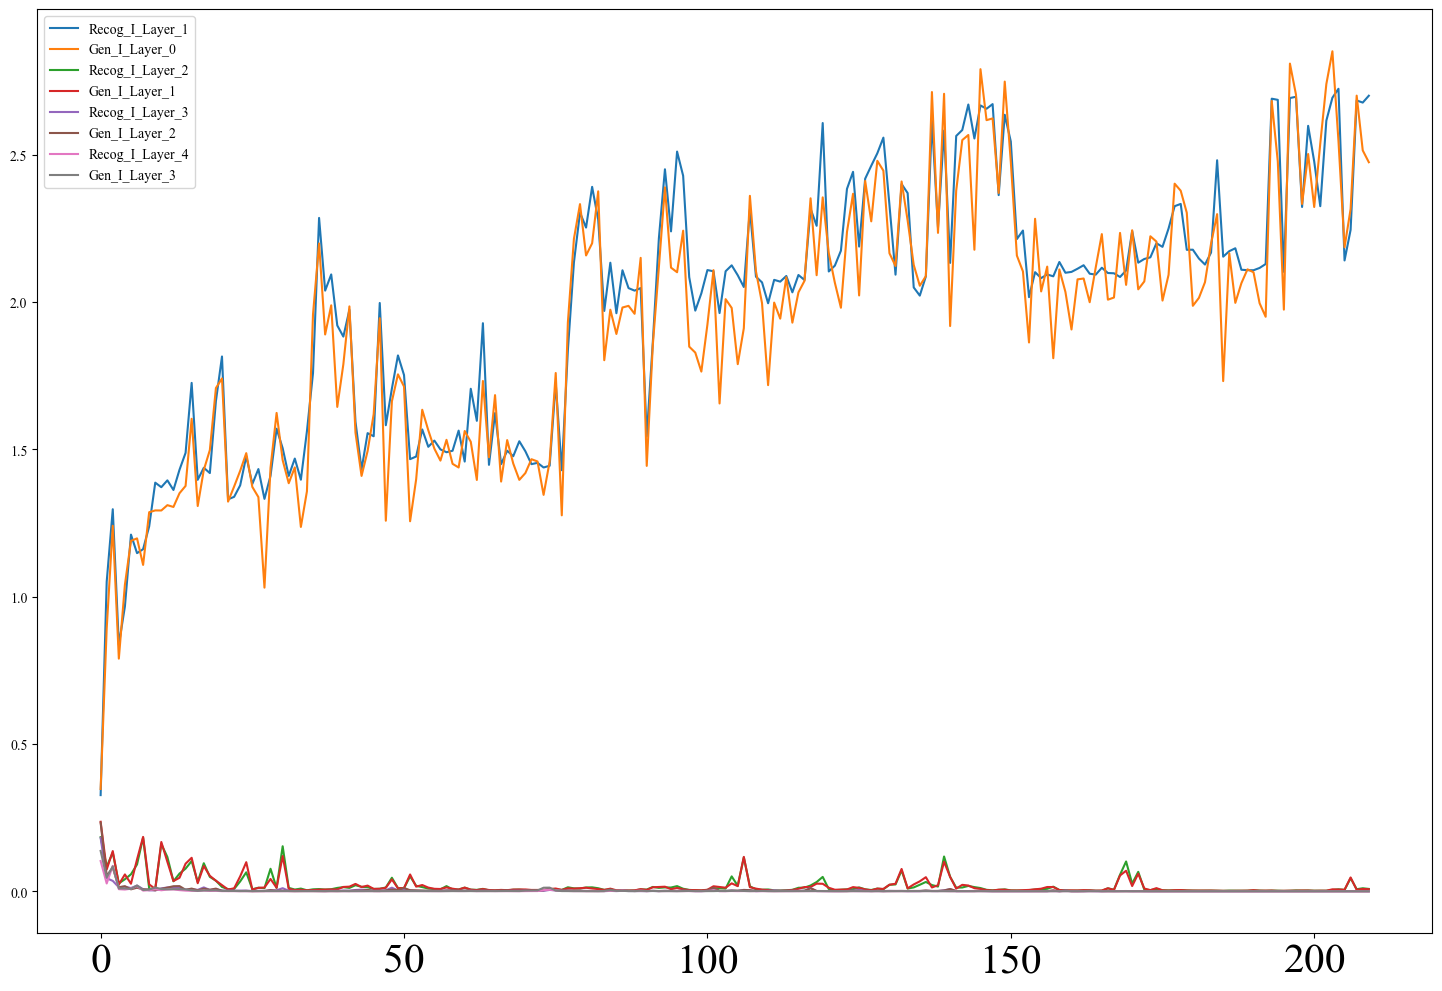

In [147]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(n_layer-2):
    ax.plot(x, np.array(Analytic_ws_online['Recog_I_Layer_'+str(i+1)]),label = 'Recog_I_Layer_'+str(i+1))
    ax.plot(x, np.array(Analytic_ws_online['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

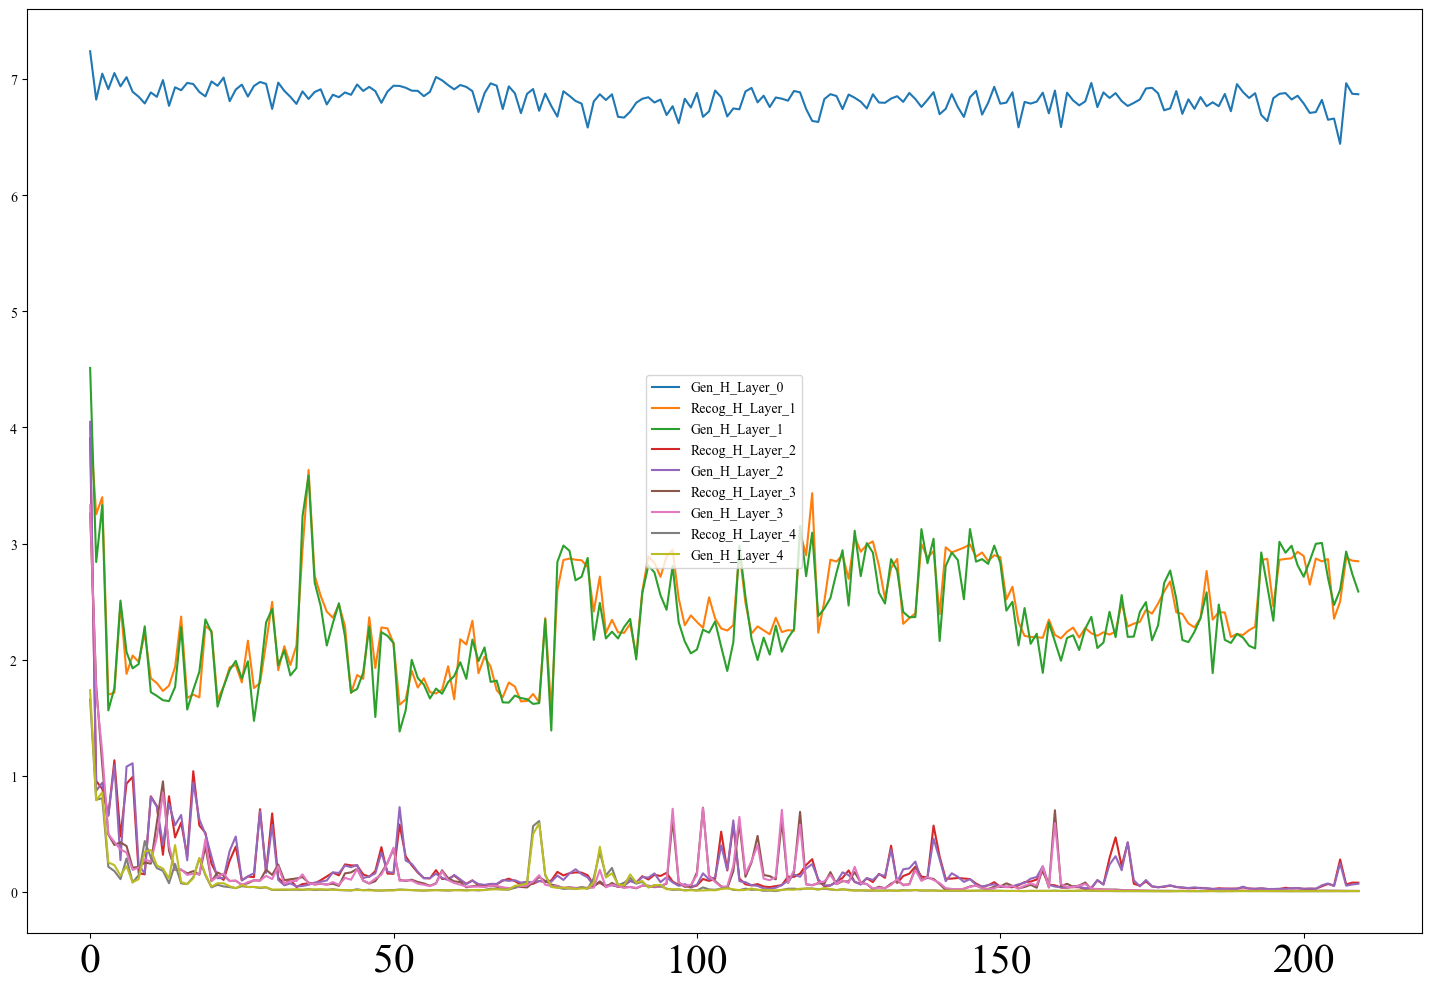

In [148]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(x, np.array(Analytic_ws_online['Gen_H_Layer_'+str(0)]),label = 'Gen_H_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

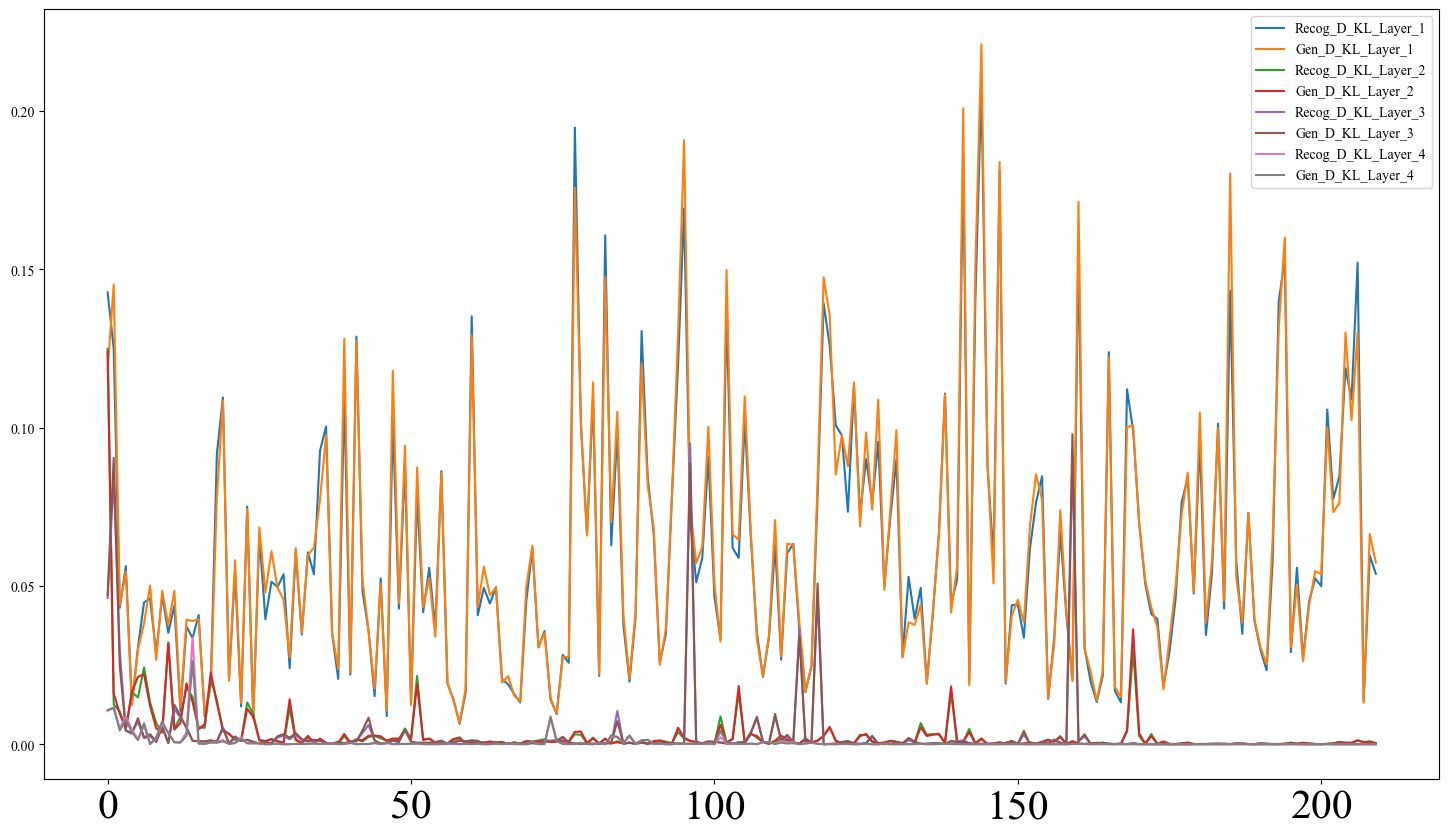

In [149]:
fig, ax = plt.subplots(figsize=(18, 10))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online['Recog_D_KL_Layer_'+str(i)]),label = 'Recog_D_KL_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online['Gen_D_KL_Layer_'+str(i)]),label = 'Gen_D_KL_Layer_'+str(i))
ax.legend()
plt.show()

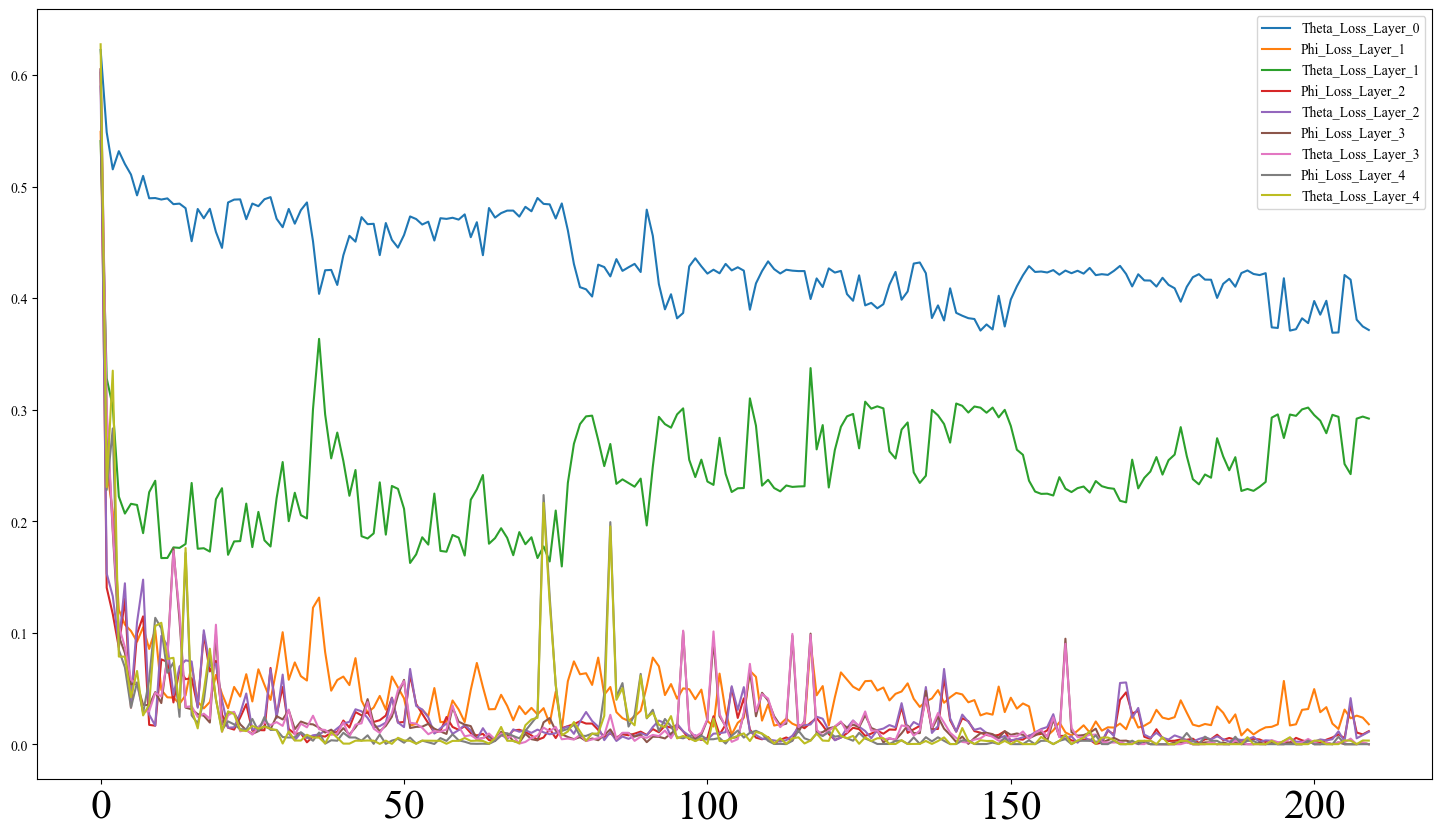

In [150]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_online['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_online['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_online['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()